# How are the emergence of social movements affected by GDP?

LSE DS105A - Data for Data Science (2024/25)

**Date**: 4/02/25

**Authors**: Chiara Franzin

**Objective**:🌟 Visualise the relationship between social movements and GDP

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio


## 1. Line Graphs Representing Correlation Between GDP and Social Movements

In [3]:
# Predefined keywords for social movements
social_movements_keywords = {
    'Black Lives Matter': ['black', 'racial', 'civil-rights', 'blm'],
    'Me Too': ['gender', 'metoo', 'sexual-abuse', 'harassment'],
    'Climate Change': ['climate', 'global-warming', 'environmental', 'sustainability']
}

In [4]:
# Query GDP data for the years 2010-2019
query_gdp_2010s = """
SELECT 
    SUBSTR(Date, 1, 4) AS Year, 
    GDP_Billions
FROM FRED
WHERE Date LIKE '201%' 
ORDER BY Year;
"""

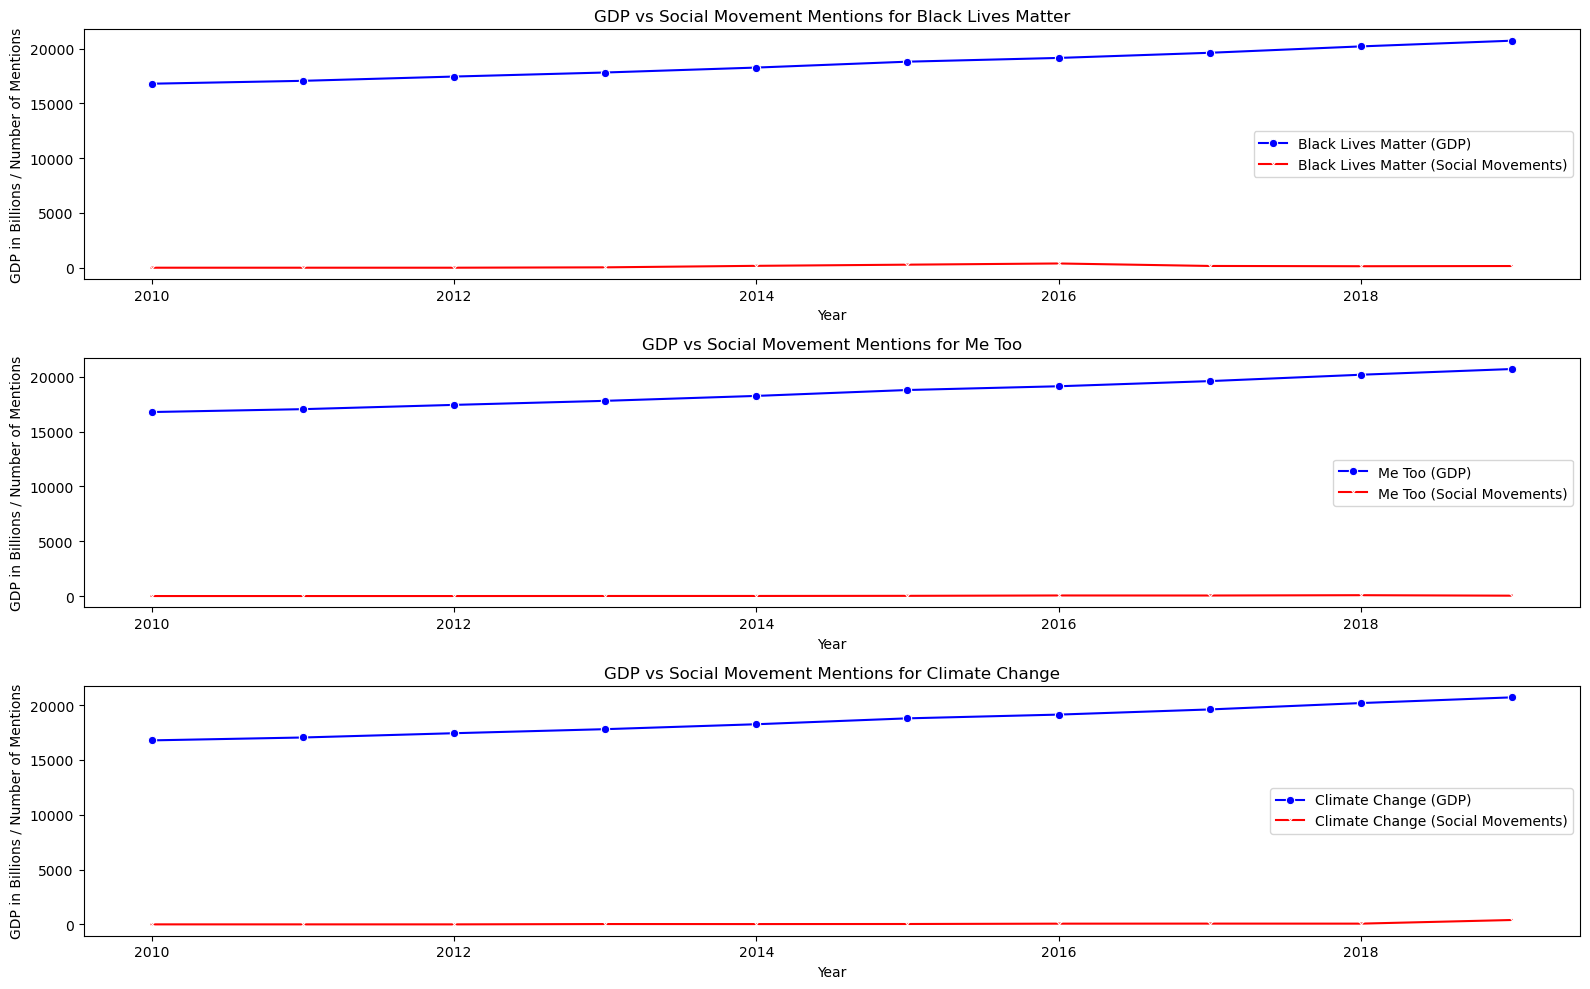

In [5]:
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

gdp_data = pd.read_sql_query(query_gdp_2010s, conn)

# Convert GDP year to integer and handle missing data
gdp_data['Year'] = gdp_data['Year'].astype(int)
gdp_data = gdp_data.set_index('Year')

# Query social movement mentions from the database for 2010-2019
movement_data = {}
for movement, terms in social_movements_keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions
    FROM SocialMovements
    WHERE ({term_conditions}) AND Date LIKE '201%'
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)
    movement_data[movement]['Year'] = movement_data[movement]['Year'].astype(int)

# Visualization: GDP vs Social Movements Mentions
plt.figure(figsize=(16, 10))

for i, movement in enumerate(social_movements_keywords.keys(), 1):
    plt.subplot(3, 1, i)

    # Merge GDP and social movement data
    combined_data = pd.merge(
        gdp_data[['GDP_Billions']], 
        movement_data[movement], 
        on='Year', 
        how='outer'
    ).fillna(0)

    # Plot the trends for GDP and Social Movements
    sns.lineplot(data=combined_data, x='Year', y='GDP_Billions', label=f'{movement} (GDP)', marker='o', color='blue')
    sns.lineplot(data=combined_data, x='Year', y='TotalMentions', label=f'{movement} (Social Movements)', marker='x', color='red')

    plt.title(f'GDP vs Social Movement Mentions for {movement}')
    plt.xlabel('Year')
    plt.ylabel('GDP in Billions / Number of Mentions')
    plt.legend()

plt.tight_layout()
plt.show()

# Close the database connection
conn.close()


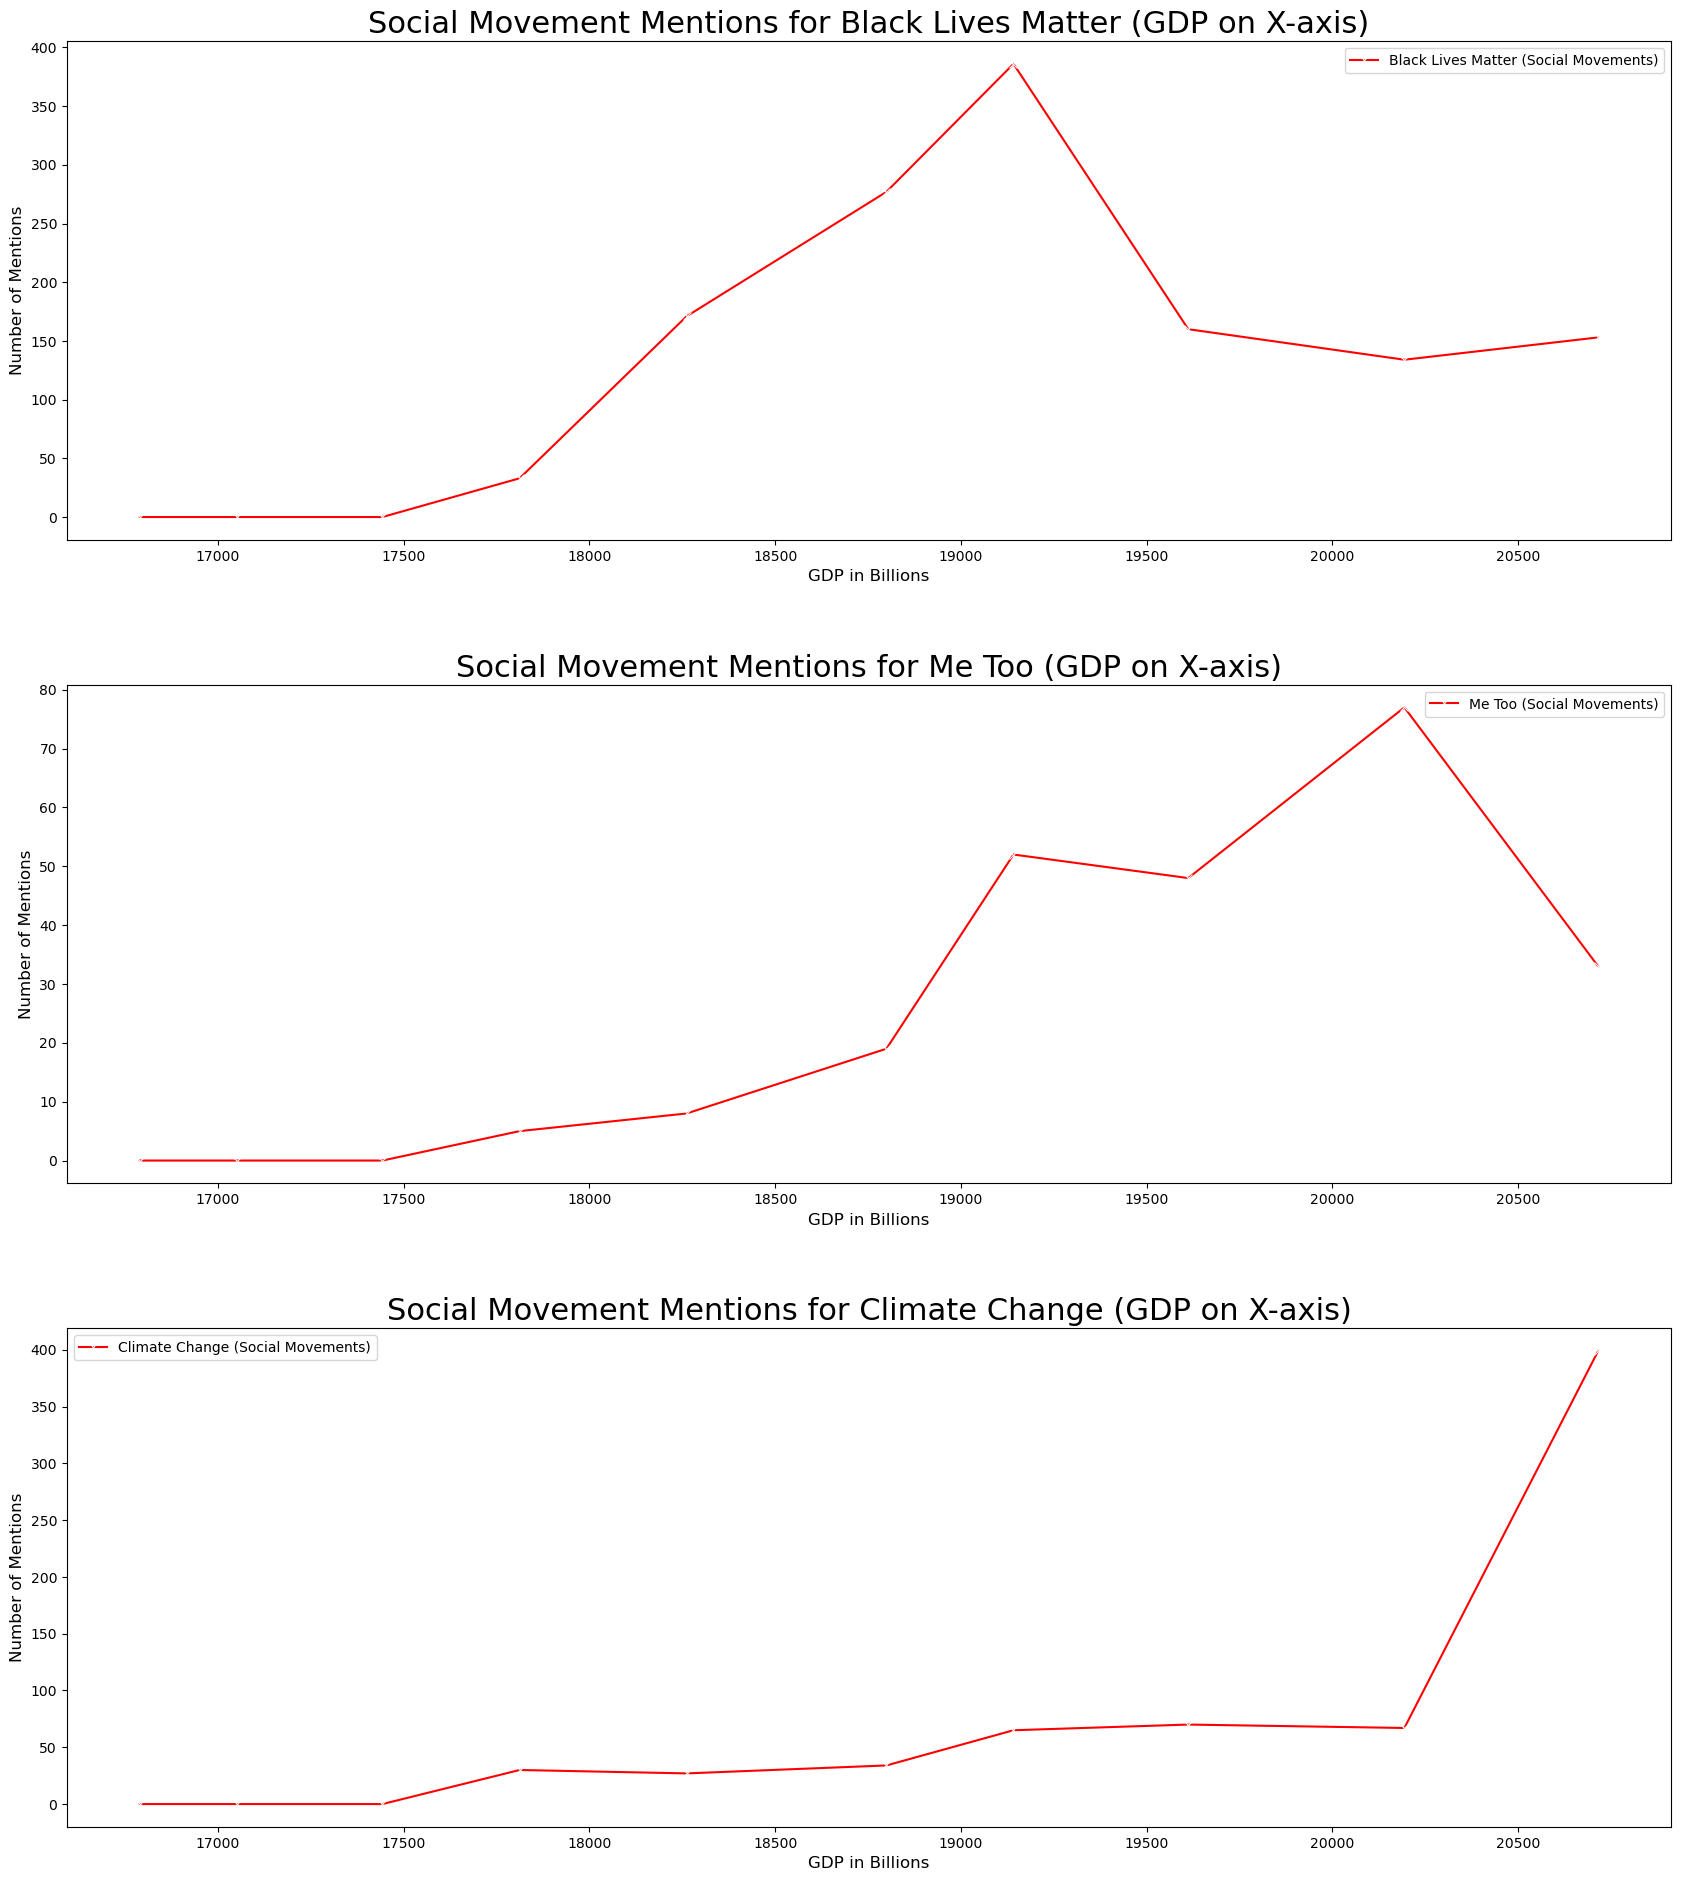

In [6]:
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

gdp_data = pd.read_sql_query(query_gdp_2010s, conn)

# Convert GDP year to integer
gdp_data['Year'] = gdp_data['Year'].astype(int)

# Query themes from the 2010s
query_2010s_art = """
SELECT 
    Topics AS Theme,
    ProductionYear AS Year
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL 
AND LENGTH(ProductionYear) = 4 
AND CAST(ProductionYear AS INTEGER) BETWEEN 2010 AND 2019;
"""
art_data_2010s = pd.read_sql_query(query_2010s_art, conn)

# Split themes by comma and explode the DataFrame
art_data_2010s['Theme'] = art_data_2010s['Theme'].str.split(", ")
art_data_2010s = art_data_2010s.explode('Theme').dropna()

# Filter art themes by social movement keywords
movement_art_counts = {}
for movement, keywords in social_movements_keywords.items():
    condition = art_data_2010s['Theme'].str.contains('|'.join(keywords), case=False, na=False)
    filtered_art = art_data_2010s[condition]
    yearly_counts = filtered_art.groupby('Year').size().reset_index(name='ArtMentions')
    movement_art_counts[movement] = yearly_counts

# Query social movement mentions from the database
movement_data = {}
for movement, terms in social_movements_keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions
    FROM SocialMovements
    WHERE ({term_conditions}) AND Date LIKE '201%'
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)

# Convert Year column in movement_data and movement_art_counts to integer for consistency
for movement in movement_art_counts:
    movement_art_counts[movement]['Year'] = movement_art_counts[movement]['Year'].astype(int)

for movement in movement_data:
    movement_data[movement]['Year'] = movement_data[movement]['Year'].astype(int)

# Visualization: Art Themes vs Social Movements with GDP on X-axis
plt.figure(figsize=(18, 20))

for i, movement in enumerate(social_movements_keywords.keys(), 1):
    plt.subplot(3, 1, i)

    # Merge art and social movement data with GDP data
    art_data_merged = pd.merge(
        movement_art_counts[movement], 
        movement_data[movement], 
        on='Year', 
        how='outer'
    ).fillna(0)

    # Merge with GDP data
    combined_data = pd.merge(
        art_data_merged,
        gdp_data[['Year', 'GDP_Billions']],
        on='Year',
        how='outer'
    ).fillna(0)

    # Plot only the social movement data (red line)
    sns.lineplot(data=combined_data, x='GDP_Billions', y='TotalMentions', label=f'{movement} (Social Movements)', marker='x', color='red')

    plt.title(f'Social Movement Mentions for {movement} (GDP on X-axis)', fontsize=22)
    plt.xlabel('GDP in Billions', fontsize=12)
    plt.ylabel('Number of Mentions', fontsize=12)
    plt.legend()

# Save the figure as an SVG file
svg_file_path = "../../website/figures/social_movements_vs_gdp.svg" 
plt.savefig(svg_file_path, format='svg', transparent=True)

plt.tight_layout(pad=5)
plt.show()


# Close the database connection
conn.close()

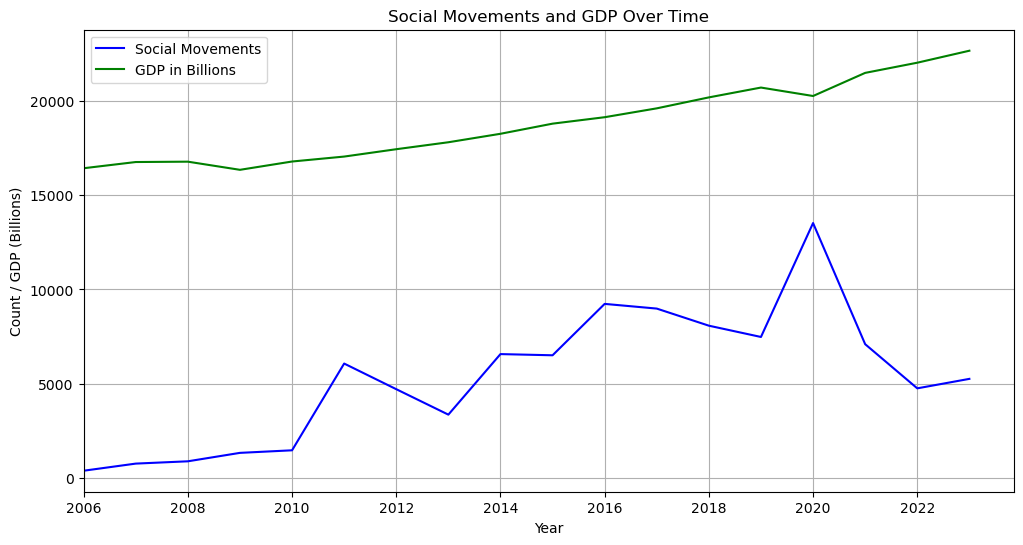

In [7]:
# Connect to the SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDELT and GDP data
gdelt_query = "SELECT Date, PrimaryActor, SecondaryActor FROM SocialMovements"
gdp_query = "SELECT Date, GDP_Billions FROM FRED"  # Assuming GDP data is in this table and column

gdelt_df = pd.read_sql_query(gdelt_query, conn)
gdp_df = pd.read_sql_query(gdp_query, conn)

# Ensure date columns are in datetime format
gdelt_df["Date"] = pd.to_datetime(gdelt_df["Date"], errors='coerce')
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')

# Drop rows with missing dates
gdelt_df.dropna(subset=["Date"], inplace=True)
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract year for aggregation
gdelt_df["Year"] = gdelt_df["Date"].dt.year
gdp_df["Year"] = gdp_df["Date"].dt.year

# Merge GDP and GDELT datasets on Year
merged_df = pd.merge(gdelt_df, gdp_df, on="Year", how="inner")

# Count the number of social movement mentions per year
social_movement_counts = gdelt_df.groupby("Year").size().reset_index(name="SocialMovementCount")
gdp_counts = gdp_df.groupby("Year")["GDP_Billions"].first().reset_index(name="GDP_Billions")

# Merge the counts for plotting
counts_df = pd.merge(social_movement_counts, gdp_counts, on="Year", how="inner")

# Plot social movements vs. GDP over time
plt.figure(figsize=(12, 6))
plt.plot(counts_df["Year"], counts_df["SocialMovementCount"], label="Social Movements", color="blue")
plt.plot(counts_df["Year"], counts_df["GDP_Billions"], label="GDP in Billions", color="green")
plt.title("Social Movements and GDP Over Time")
plt.xlabel("Year")
plt.ylabel("Count / GDP (Billions)")
plt.legend()  # Ensure legend is shown
plt.grid(True)

# Set x-axis to start at 2006 and use a 2-year interval
plt.xlim(left=2006)
plt.xticks(np.arange(2006, counts_df["Year"].max() + 1, 2))  # 2-year interval on x-axis

svg_file_path = "../../website/figures/social_movements_gdp_per_year.svg" 
plt.savefig(svg_file_path, format='svg')

plt.show()

conn.close()


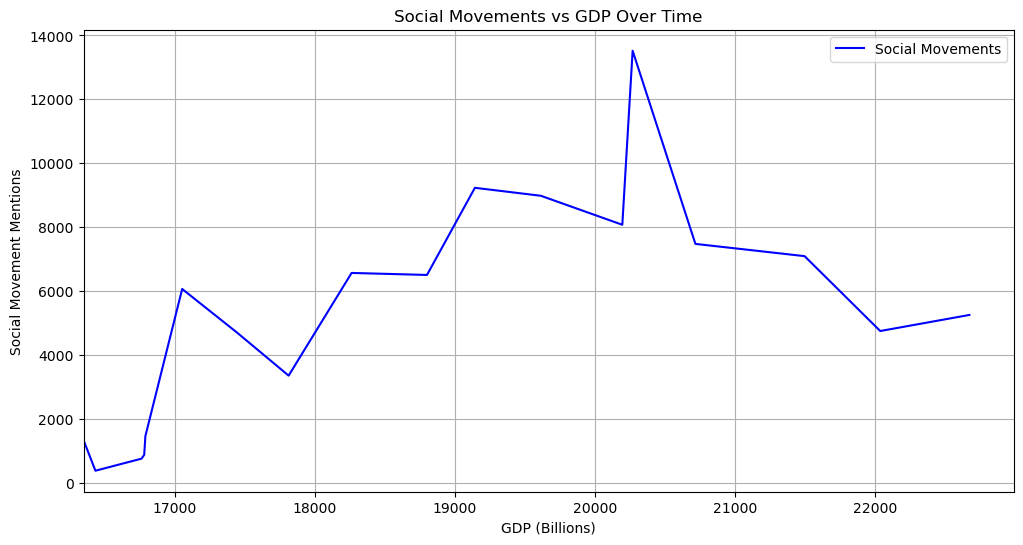

In [8]:
# Connect to the SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDELT and GDP data
gdelt_query = "SELECT Date, PrimaryActor, SecondaryActor FROM SocialMovements"
gdp_query = "SELECT Date, GDP_Billions FROM FRED"  # Assuming GDP data is in this table and column

gdelt_df = pd.read_sql_query(gdelt_query, conn)
gdp_df = pd.read_sql_query(gdp_query, conn)

# Ensure date columns are in datetime format
gdelt_df["Date"] = pd.to_datetime(gdelt_df["Date"], errors='coerce')
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')

# Drop rows with missing dates
gdelt_df.dropna(subset=["Date"], inplace=True)
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract year for aggregation
gdelt_df["Year"] = gdelt_df["Date"].dt.year
gdp_df["Year"] = gdp_df["Date"].dt.year

# Merge GDP and GDELT datasets on Year
merged_df = pd.merge(gdelt_df, gdp_df, on="Year", how="inner")

# Count the number of social movement mentions per year
social_movement_counts = gdelt_df.groupby("Year").size().reset_index(name="SocialMovementCount")
gdp_counts = gdp_df.groupby("Year")["GDP_Billions"].first().reset_index(name="GDP_Billions")

# Merge the counts for plotting
counts_df = pd.merge(social_movement_counts, gdp_counts, on="Year", how="inner")

# Sort by GDP_Billions to ensure points are connected to the closest point to the right
counts_df = counts_df.sort_values("GDP_Billions")

# Plot social movements vs. GDP (GDP on x-axis)
plt.figure(figsize=(12, 6))
plt.plot(counts_df["GDP_Billions"], counts_df["SocialMovementCount"], label="Social Movements", color="blue")
plt.title("Social Movements vs GDP Over Time")
plt.xlabel("GDP (Billions)")
plt.ylabel("Social Movement Mentions")
plt.legend()  # Ensure legend is shown
plt.grid(True)

# Set x-axis to start from minimum GDP value
plt.xlim(left=counts_df["GDP_Billions"].min())

# Save as SVG
svg_file_path = "../../website/figures/social_movements_gdp_overtime.svg" 
plt.savefig(svg_file_path, format='svg')

plt.show()

conn.close()


## 2. Bubble graphs representing relationship between GDP growth rate and social movement sentiment

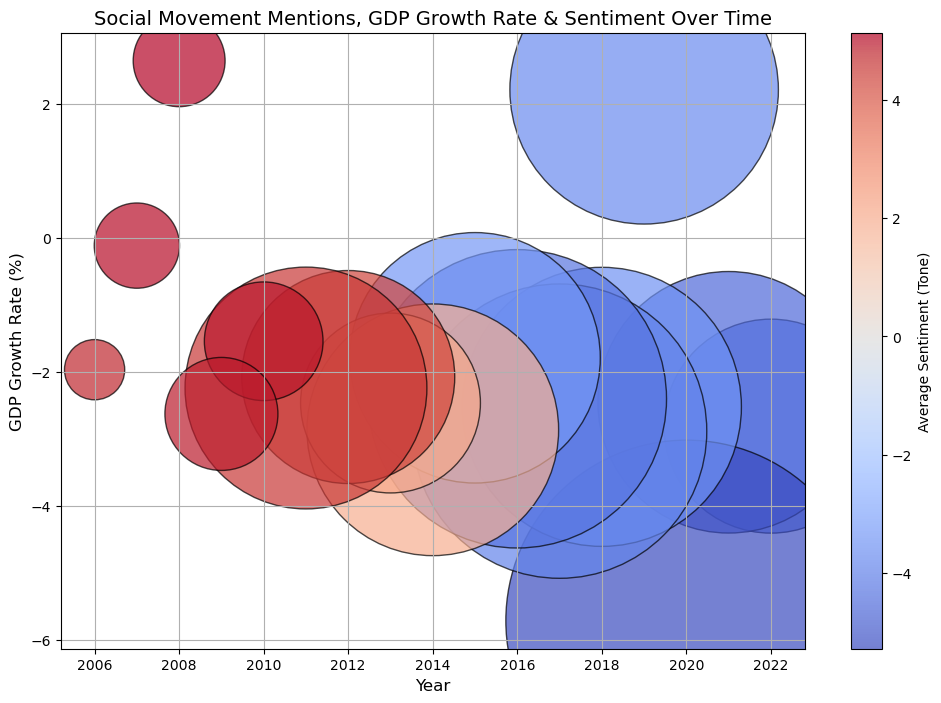

In [9]:
# Connect to the SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDP data
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_df = pd.read_sql_query(gdp_query, conn)

# Query Social Movements data
social_query = """
SELECT SUBSTR(Date, 1, 4) AS Year, COUNT(*) AS NumMentions, AVG(AvgTone) AS AvgTone
FROM SocialMovements
GROUP BY Year
ORDER BY Year;
"""
social_df = pd.read_sql_query(social_query, conn)

# Ensure date column is in datetime format
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract Year from GDP data and convert to integer
gdp_df["Year"] = gdp_df["Date"].dt.year.astype(int)

# Convert Year column in social_df to integer
social_df["Year"] = social_df["Year"].astype(int)

# Calculate GDP growth rate
gdp_df["GDP_Growth"] = gdp_df["GDP_Billions"].pct_change() * 100  # Convert to percentage
gdp_df.dropna(inplace=True)  # Remove first row with NaN growth rate

# Merge GDP and social movements data on Year
merged_df = pd.merge(gdp_df, social_df, on="Year", how="inner")

# Create Bubble Chart
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    merged_df["Year"], 
    merged_df["GDP_Growth"], 
    s=merged_df["NumMentions"] * 5,  # Scale bubble size
    c=merged_df["AvgTone"],  # Color by sentiment
    cmap="coolwarm",  # Blue for negative, red for positive
    alpha=0.7,  # Transparency for clarity
    edgecolors="k"  # Black edge for contrast
)

# Add color bar for sentiment
cbar = plt.colorbar(scatter)
cbar.set_label("Average Sentiment (Tone)")

# Labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("GDP Growth Rate (%)", fontsize=12)
plt.title("Social Movement Mentions, GDP Growth Rate & Sentiment Over Time", fontsize=14)
plt.grid(True)

plt.show()

conn.close()


In the graph below I'm trying to make the bubble graph above clearer.

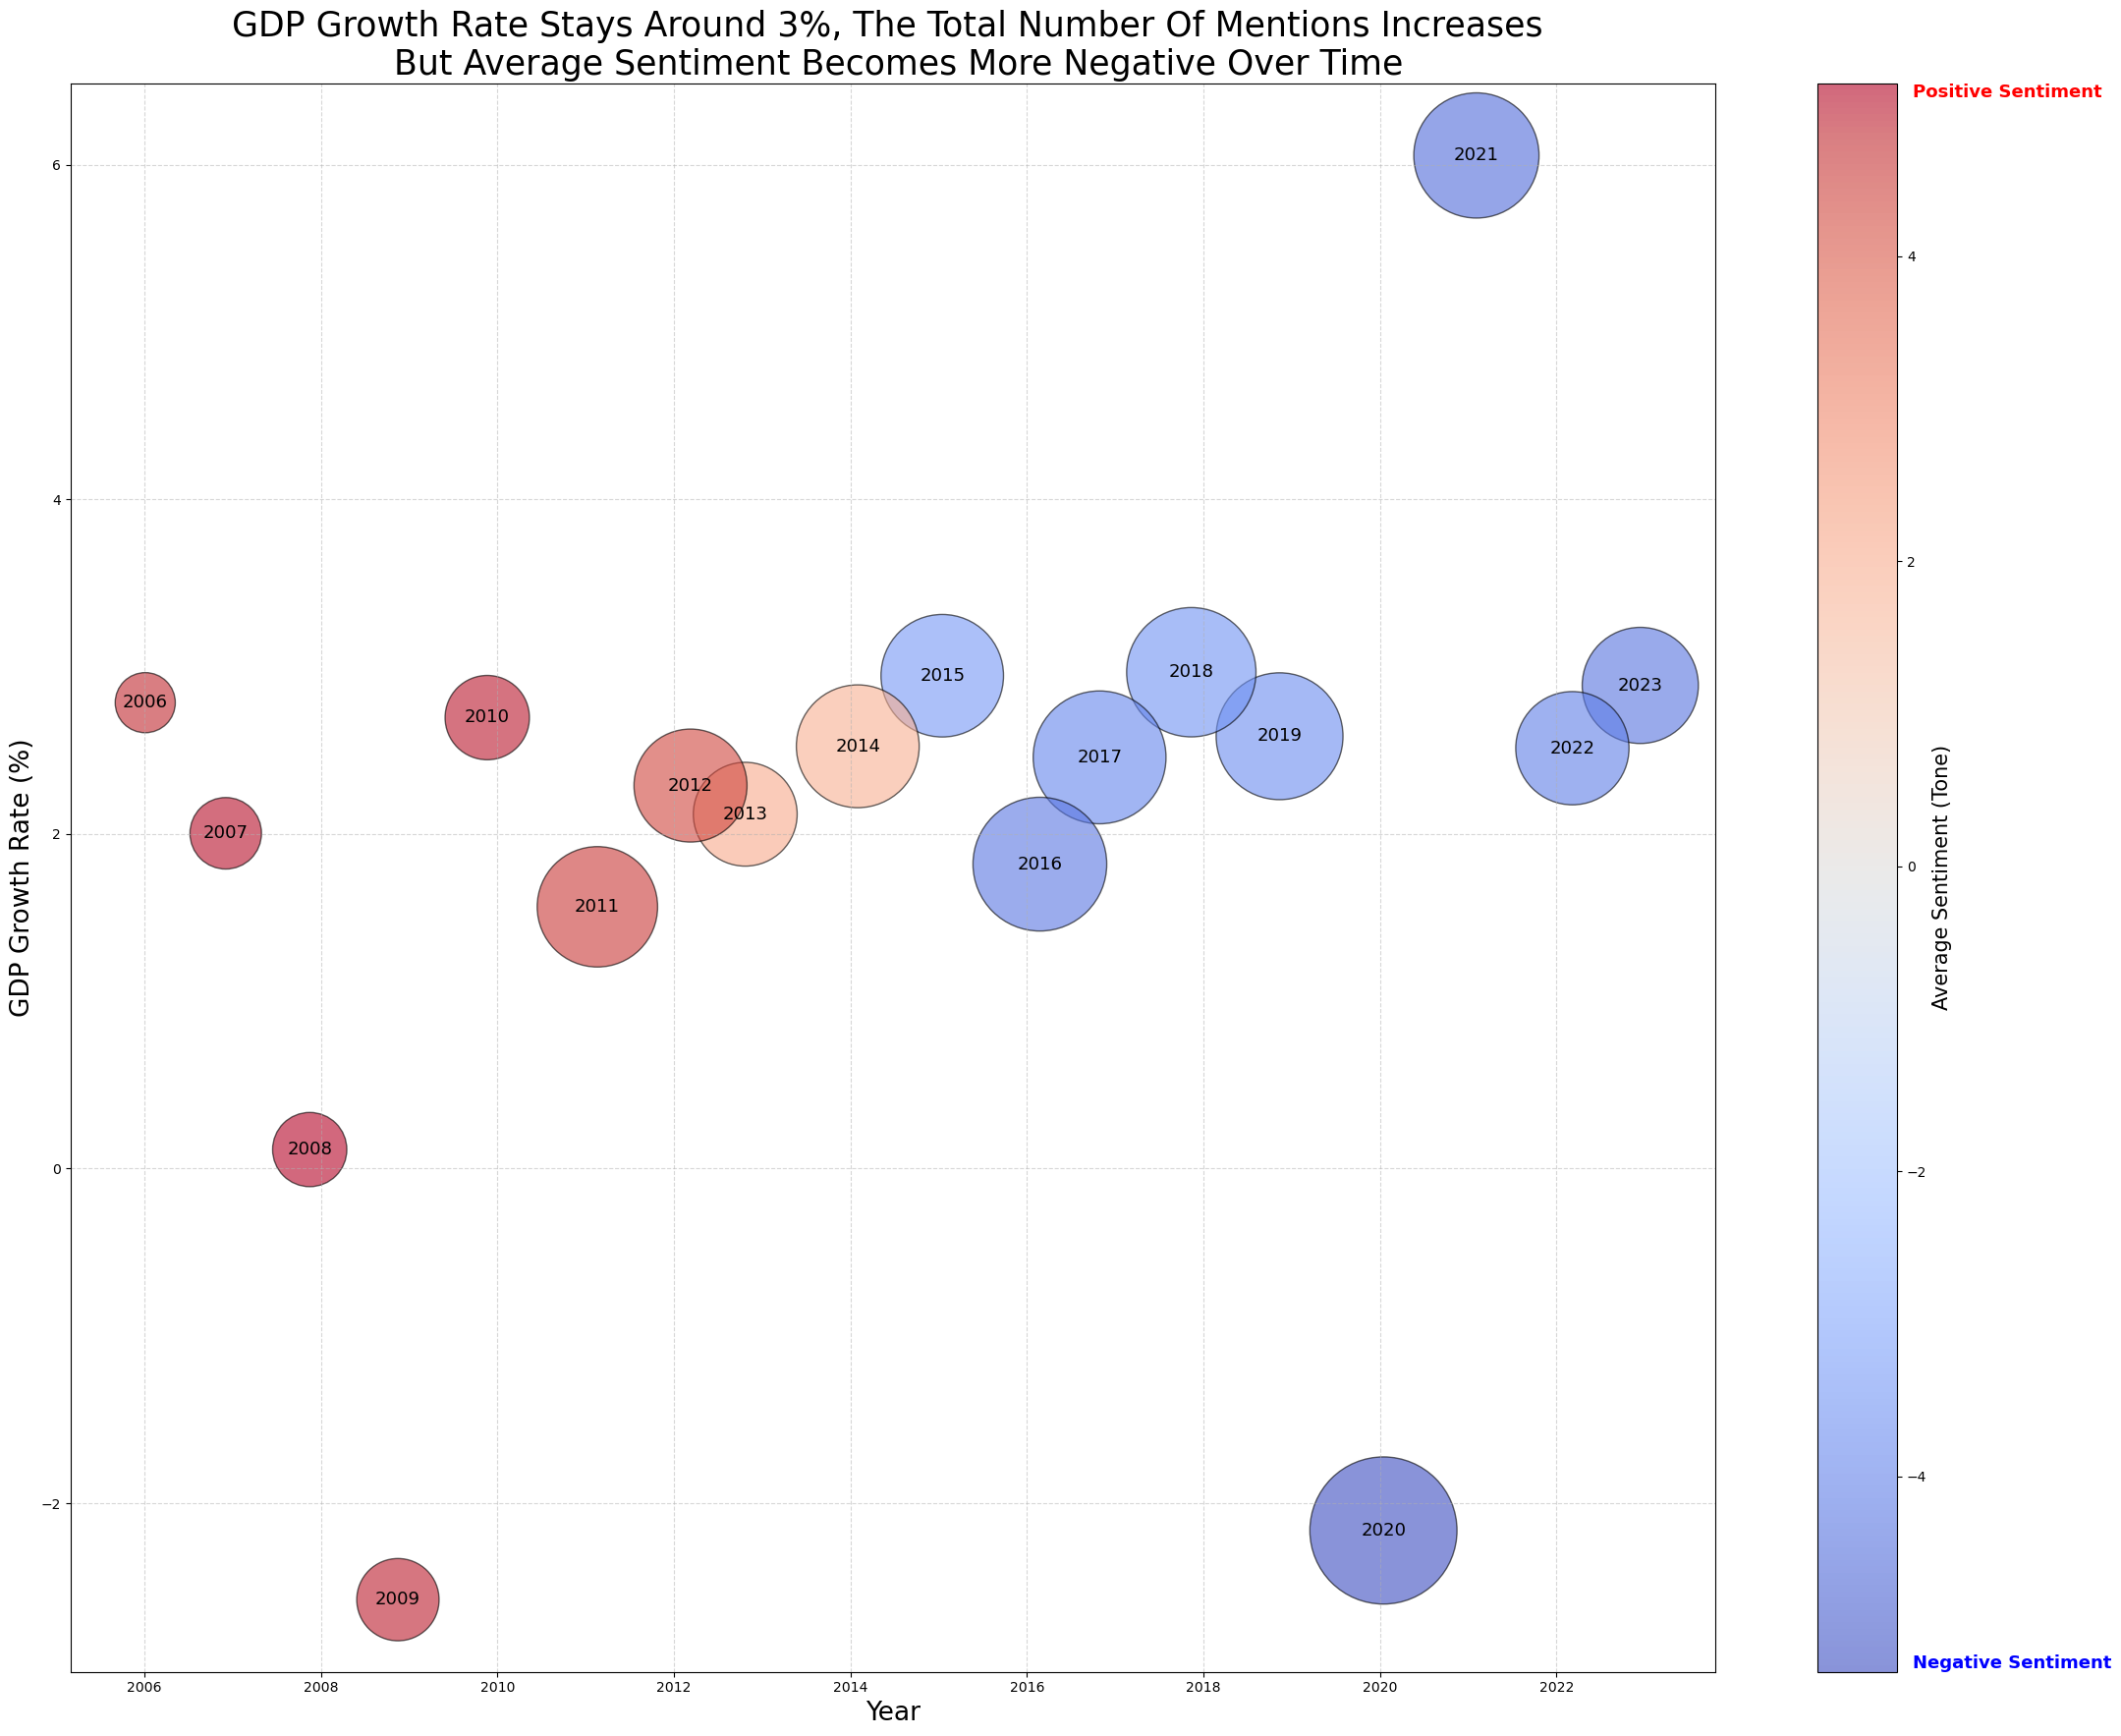

In [34]:
# Connect to SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDP data
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_df = pd.read_sql_query(gdp_query, conn)

# Query Social Movements data
social_query = """
SELECT SUBSTR(Date, 1, 4) AS Year, COUNT(*) AS NumMentions, AVG(AvgTone) AS AvgTone
FROM SocialMovements
GROUP BY Year
ORDER BY Year;
"""
social_df = pd.read_sql_query(social_query, conn)

# Ensure date column is in datetime format
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract Year from GDP data and convert to integer
gdp_df["Year"] = gdp_df["Date"].dt.year.astype(int)

# Convert Year column in social_df to integer
social_df["Year"] = social_df["Year"].astype(int)

# Calculate GDP growth rate
gdp_df = gdp_df.sort_values("Year", ascending=True) # Sort by Year in ascending order to ensure correct GDP growth calculation
gdp_df["GDP_Growth"] = ((gdp_df["GDP_Billions"] - gdp_df["GDP_Billions"].shift(1)) / gdp_df["GDP_Billions"].shift(1)) * 100
gdp_df.dropna(inplace=True)
gdp_df = gdp_df.sort_values("Year", ascending=False)


# Merge GDP and social movements data on Year
merged_df = pd.merge(gdp_df, social_df, on="Year", how="inner")

# Jittering to avoid overlap
np.random.seed(42)  # For consistent results
jitter = np.random.uniform(-0.2, 0.2, size=len(merged_df))

# Create Bubble Chart with Adjustments
plt.figure(figsize=(27,21))
scatter = plt.scatter(
    merged_df["Year"] + jitter,  # Jitter applied to Year for visibility
    merged_df["GDP_Growth"], 
    s=np.sqrt(merged_df["NumMentions"]) * 100,  # Use sqrt scale for better spread
    c=merged_df["AvgTone"],  # Color by sentiment
    cmap="coolwarm",  # Blue for negative, red for positive
    alpha=0.6,  # Adjust opacity for overlapping visibility
    edgecolors="k"  # Black edge for better contrast
)

# Add color bar for sentiment
cbar = plt.colorbar(scatter)
cbar.set_label("Average Sentiment (Tone)", fontsize=15)

# Get color bar axis limits
cbar_min, cbar_max = cbar.ax.get_ylim()

# Add labels at the edges
cbar.ax.text(1.2, cbar_min, "Negative Sentiment", va="bottom", ha="left", fontsize=13, color="blue", weight="bold")
cbar.ax.text(1.2, cbar_max, "Positive Sentiment", va="top", ha="left", fontsize=13, color="red", weight="bold")

# Annotate bubbles with Year
for i, row in merged_df.iterrows():
    plt.text(row["Year"] + jitter[i], row["GDP_Growth"], str(row["Year"]), fontsize=13, ha='center', va='center', color='black')

# Labels and title
plt.xlabel("Year", fontsize=19)
plt.ylabel("GDP Growth Rate (%)", fontsize=19)
plt.title("GDP Growth Rate Stays Around 3%, The Total Number Of Mentions Increases \n But Average Sentiment Becomes More Negative Over Time", fontsize=25)
plt.xticks(np.arange(merged_df["Year"].min(), merged_df["Year"].max() + 1, 2))  # Set x-axis intervals to 2 years
plt.grid(True, linestyle="--", alpha=0.5)


svg_file_path = "../../website/figures/bubble_graph.svg" 
plt.savefig(svg_file_path, format='svg', transparent=True)

plt.show()

conn.close()


   Year  GDP_Billions  GDP_Growth
0  2023     22671.096    2.887556
1  2022     22034.828    2.512375
2  2021     21494.798    6.055053
3  2020     20267.585   -2.163029
4  2019     20715.671    2.583825
5  2018     20193.896    2.966505
6  2017     19612.102    2.457622
7  2016     19141.672    1.819451
8  2015     18799.622    2.945550
9  2014     18261.714    2.523820


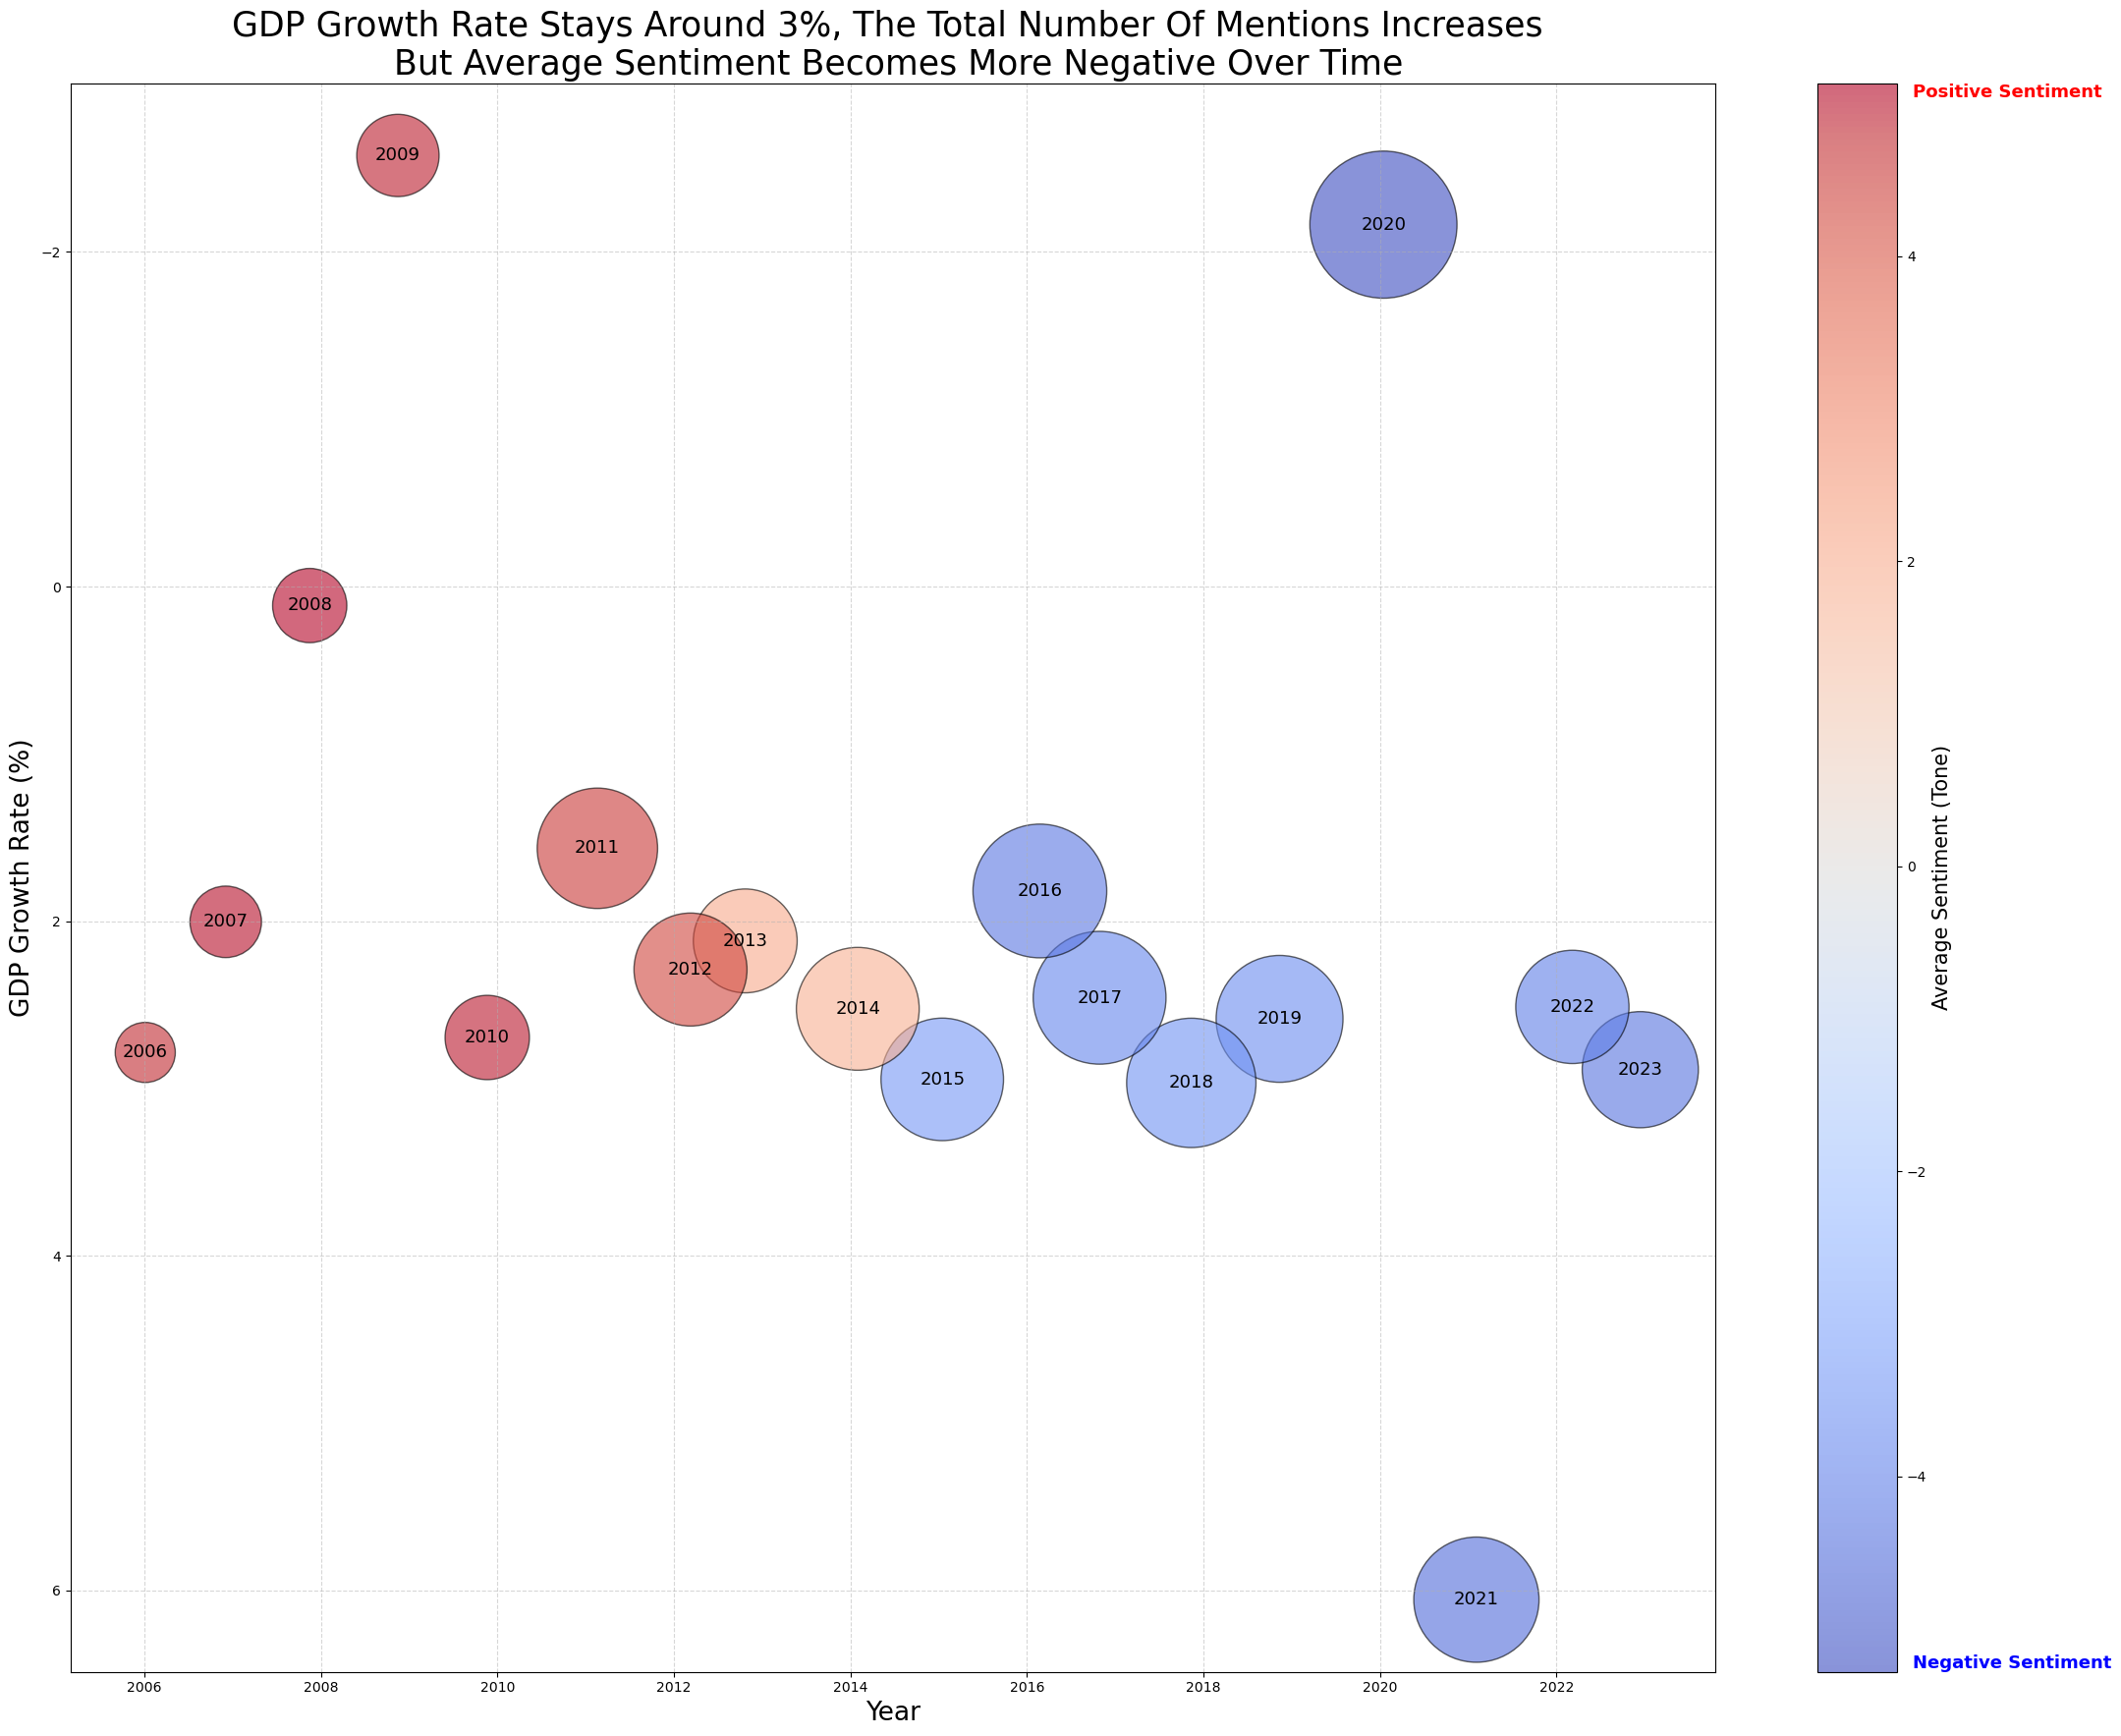

In [33]:
# Connect to SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDP data
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_df = pd.read_sql_query(gdp_query, conn)

# Query Social Movements data
social_query = """
SELECT SUBSTR(Date, 1, 4) AS Year, COUNT(*) AS NumMentions, AVG(AvgTone) AS AvgTone
FROM SocialMovements
GROUP BY Year
ORDER BY Year;
"""
social_df = pd.read_sql_query(social_query, conn)

# Ensure date column is in datetime format
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract Year from GDP data and convert to integer
gdp_df["Year"] = gdp_df["Date"].dt.year.astype(int)

# Convert Year column in social_df to integer
social_df["Year"] = social_df["Year"].astype(int)

# Sort by Year in ascending order to ensure correct GDP growth calculation
gdp_df = gdp_df.sort_values("Year", ascending=True)

# Correct GDP Growth Rate Calculation
gdp_df["GDP_Growth"] = ((gdp_df["GDP_Billions"] - gdp_df["GDP_Billions"].shift(1)) / gdp_df["GDP_Billions"].shift(1)) * 100

# Drop the first row where GDP_Growth is NaN
gdp_df.dropna(inplace=True)

# If needed, re-sort in descending order for display
gdp_df = gdp_df.sort_values("Year", ascending=False)


# Debugging: Check GDP Growth Calculation
print(gdp_df[["Year", "GDP_Billions", "GDP_Growth"]].head(10))  # Remove after verifying correctness

# Merge GDP and social movements data on Year
merged_df = pd.merge(gdp_df, social_df, on="Year", how="inner")

# Jittering to avoid overlap
np.random.seed(42)  # For consistent results
jitter = np.random.uniform(-0.2, 0.2, size=len(merged_df))

# **Create Bubble Chart with Adjustments**
plt.figure(figsize=(27,21))
scatter = plt.scatter(
    merged_df["Year"] + jitter,  # Apply jitter for visibility
    merged_df["GDP_Growth"], 
    s=np.sqrt(merged_df["NumMentions"]) * 100,  # Use sqrt scale for better spread
    c=merged_df["AvgTone"],  # Color by sentiment
    cmap="coolwarm",  # Blue for negative, red for positive
    alpha=0.6,  # Adjust opacity for overlapping visibility
    edgecolors="k"  # Black edge for better contrast
)

# **Fix: Ensure Y-Axis is Not Inverted**
plt.gca().invert_yaxis()  # If the graph is still flipped, try removing this line

# Add color bar for sentiment
cbar = plt.colorbar(scatter)
cbar.set_label("Average Sentiment (Tone)", fontsize=15)

# Get color bar axis limits
cbar_min, cbar_max = cbar.ax.get_ylim()

# Add labels at the edges
cbar.ax.text(1.2, cbar_min, "Negative Sentiment", va="bottom", ha="left", fontsize=13, color="blue", weight="bold")
cbar.ax.text(1.2, cbar_max, "Positive Sentiment", va="top", ha="left", fontsize=13, color="red", weight="bold")

# Annotate bubbles with Year
for i, row in merged_df.iterrows():
    plt.text(row["Year"] + jitter[i], row["GDP_Growth"], str(row["Year"]), fontsize=13, ha='center', va='center', color='black')

# Labels and title
plt.xlabel("Year", fontsize=19)
plt.ylabel("GDP Growth Rate (%)", fontsize=19)
plt.title("GDP Growth Rate Stays Around 3%, The Total Number Of Mentions Increases \n But Average Sentiment Becomes More Negative Over Time", fontsize=25)

# Set x-axis intervals to 2 years
plt.xticks(np.arange(merged_df["Year"].min(), merged_df["Year"].max() + 1, 2))  
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

# Close database connection
conn.close()

Now we will make this bubble graph more color blind friendly.

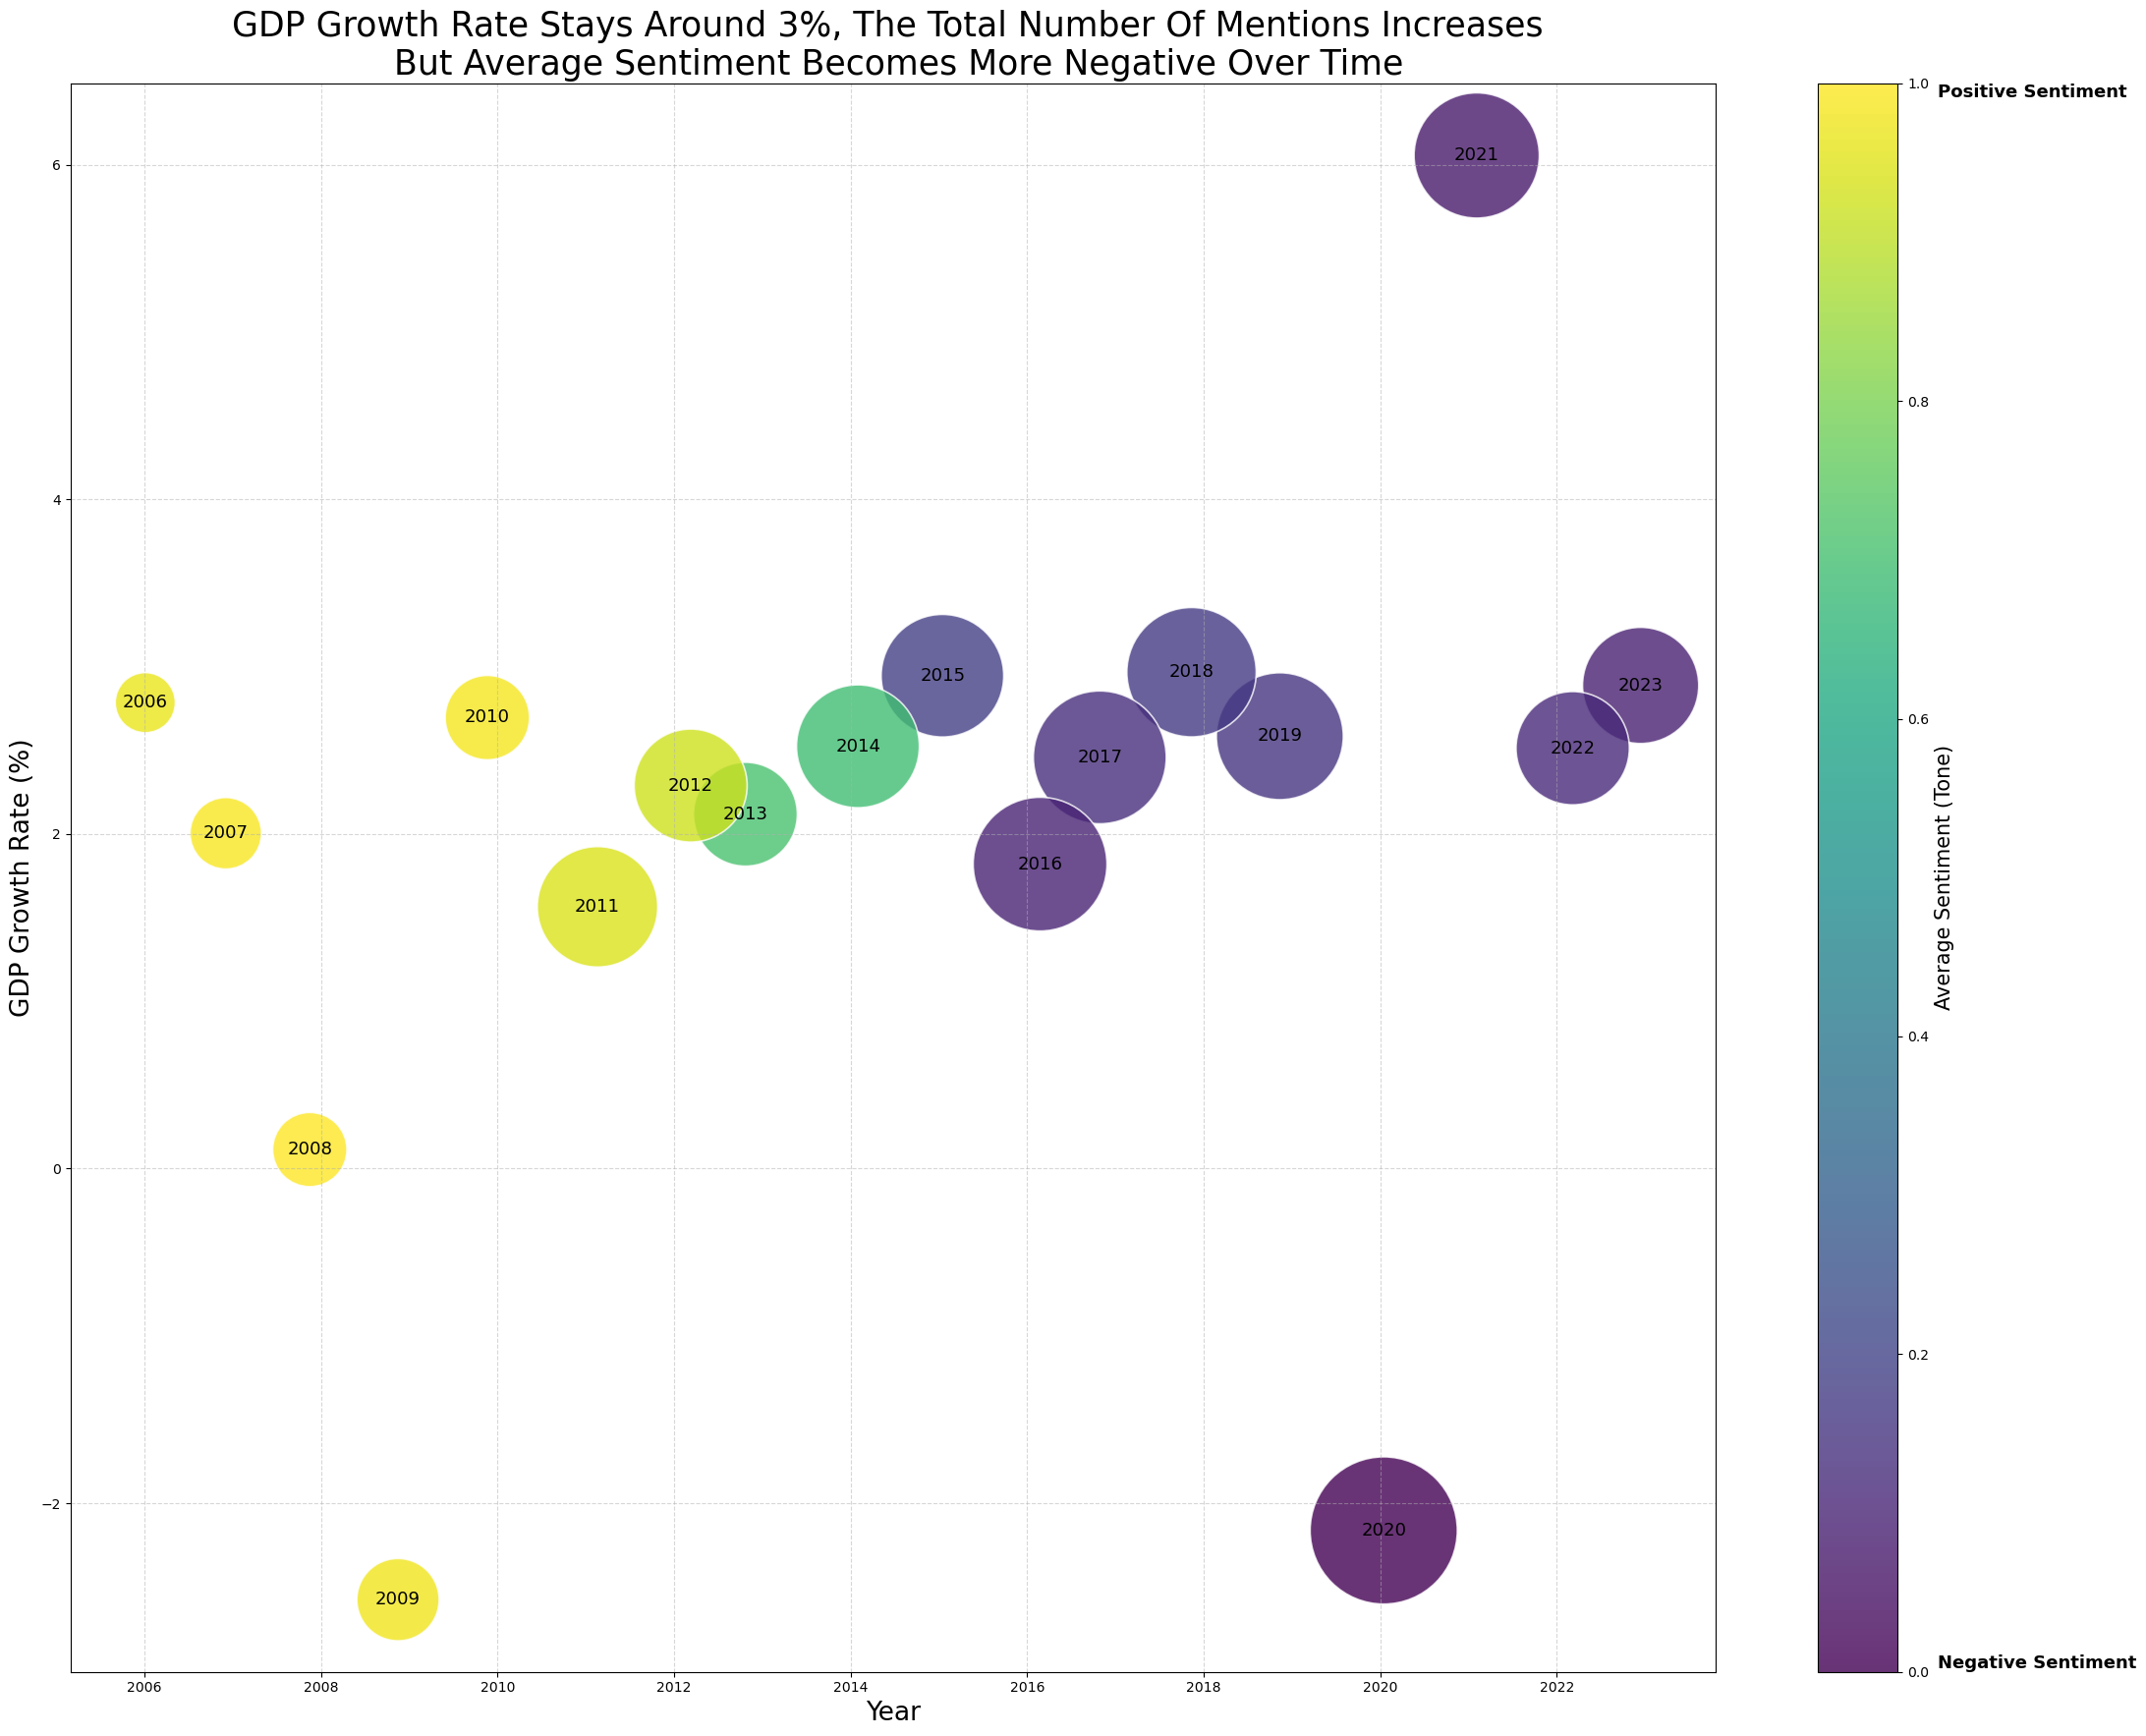

In [49]:
# Connect to SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDP data
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_df = pd.read_sql_query(gdp_query, conn)

# Query Social Movements data
social_query = """
SELECT SUBSTR(Date, 1, 4) AS Year, COUNT(*) AS NumMentions, AVG(AvgTone) AS AvgTone
FROM SocialMovements
GROUP BY Year
ORDER BY Year;
"""
social_df = pd.read_sql_query(social_query, conn)

# Ensure date column is in datetime format
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract Year from GDP data and convert to integer
gdp_df["Year"] = gdp_df["Date"].dt.year.astype(int)

# Convert Year column in social_df to integer
social_df["Year"] = social_df["Year"].astype(int)

# Calculate GDP growth rate
gdp_df = gdp_df.sort_values("Year", ascending=True) # Sort by Year in ascending order to ensure correct GDP growth calculation
gdp_df["GDP_Growth"] = ((gdp_df["GDP_Billions"] - gdp_df["GDP_Billions"].shift(1)) / gdp_df["GDP_Billions"].shift(1)) * 100
gdp_df.dropna(inplace=True)
gdp_df = gdp_df.sort_values("Year", ascending=False)

# Merge GDP and social movements data on Year
merged_df = pd.merge(gdp_df, social_df, on="Year", how="inner")

# Jittering to avoid overlap
np.random.seed(42)  # For consistent results
jitter = np.random.uniform(-0.2, 0.2, size=len(merged_df))

# === Colorblind-Friendly Palette ===
# "viridis" is great for colorblind users (monotonic perceptual scale)
cmap = plt.cm.viridis

# Normalize AvgTone values to match colormap
norm = mcolors.Normalize(vmin=merged_df["AvgTone"].min(), vmax=merged_df["AvgTone"].max())

# Create Bubble Chart with Adjustments
plt.figure(figsize=(27,21))
scatter = plt.scatter(
    merged_df["Year"] + jitter,  # Jitter applied to Year for visibility
    merged_df["GDP_Growth"], 
    s=np.sqrt(merged_df["NumMentions"]) * 100,  # Use sqrt scale for better spread
    c=cmap(norm(merged_df["AvgTone"])),  # Apply color mapping from viridis
    alpha=0.8,  # Higher opacity for better visibility
    edgecolors="white",  # White edges improve contrast
    linewidth=1.2  # Make edges thicker for clarity
)

# Add color bar for sentiment
cbar = plt.colorbar(scatter)
cbar.set_label("Average Sentiment (Tone)", fontsize=15)

# Get color bar axis limits
cbar_min, cbar_max = cbar.ax.get_ylim()

# Add labels at the edges in high-contrast colors
cbar.ax.text(1.5, cbar_min, "Negative Sentiment", va="bottom", ha="left", fontsize=13, color="black", weight="bold")
cbar.ax.text(1.5, cbar_max, "Positive Sentiment", va="top", ha="left", fontsize=13, color="black", weight="bold")

# Add annotations for individual years
for i, row in merged_df.iterrows():
    plt.text(row["Year"] + jitter[i], row["GDP_Growth"], str(row["Year"]), fontsize=13, ha='center', va='center', color='black')

# Labels and title
plt.xlabel("Year", fontsize=19)
plt.ylabel("GDP Growth Rate (%)", fontsize=19)
plt.title("GDP Growth Rate Stays Around 3%, The Total Number Of Mentions Increases \n But Average Sentiment Becomes More Negative Over Time", fontsize=25)
plt.xticks(np.arange(merged_df["Year"].min(), merged_df["Year"].max() + 1, 2))  # Set x-axis intervals to 2 years
plt.grid(True, linestyle="--", alpha=0.5)


plt.show()

conn.close()


Now I'm changing the graph so it has a title and subtitle.

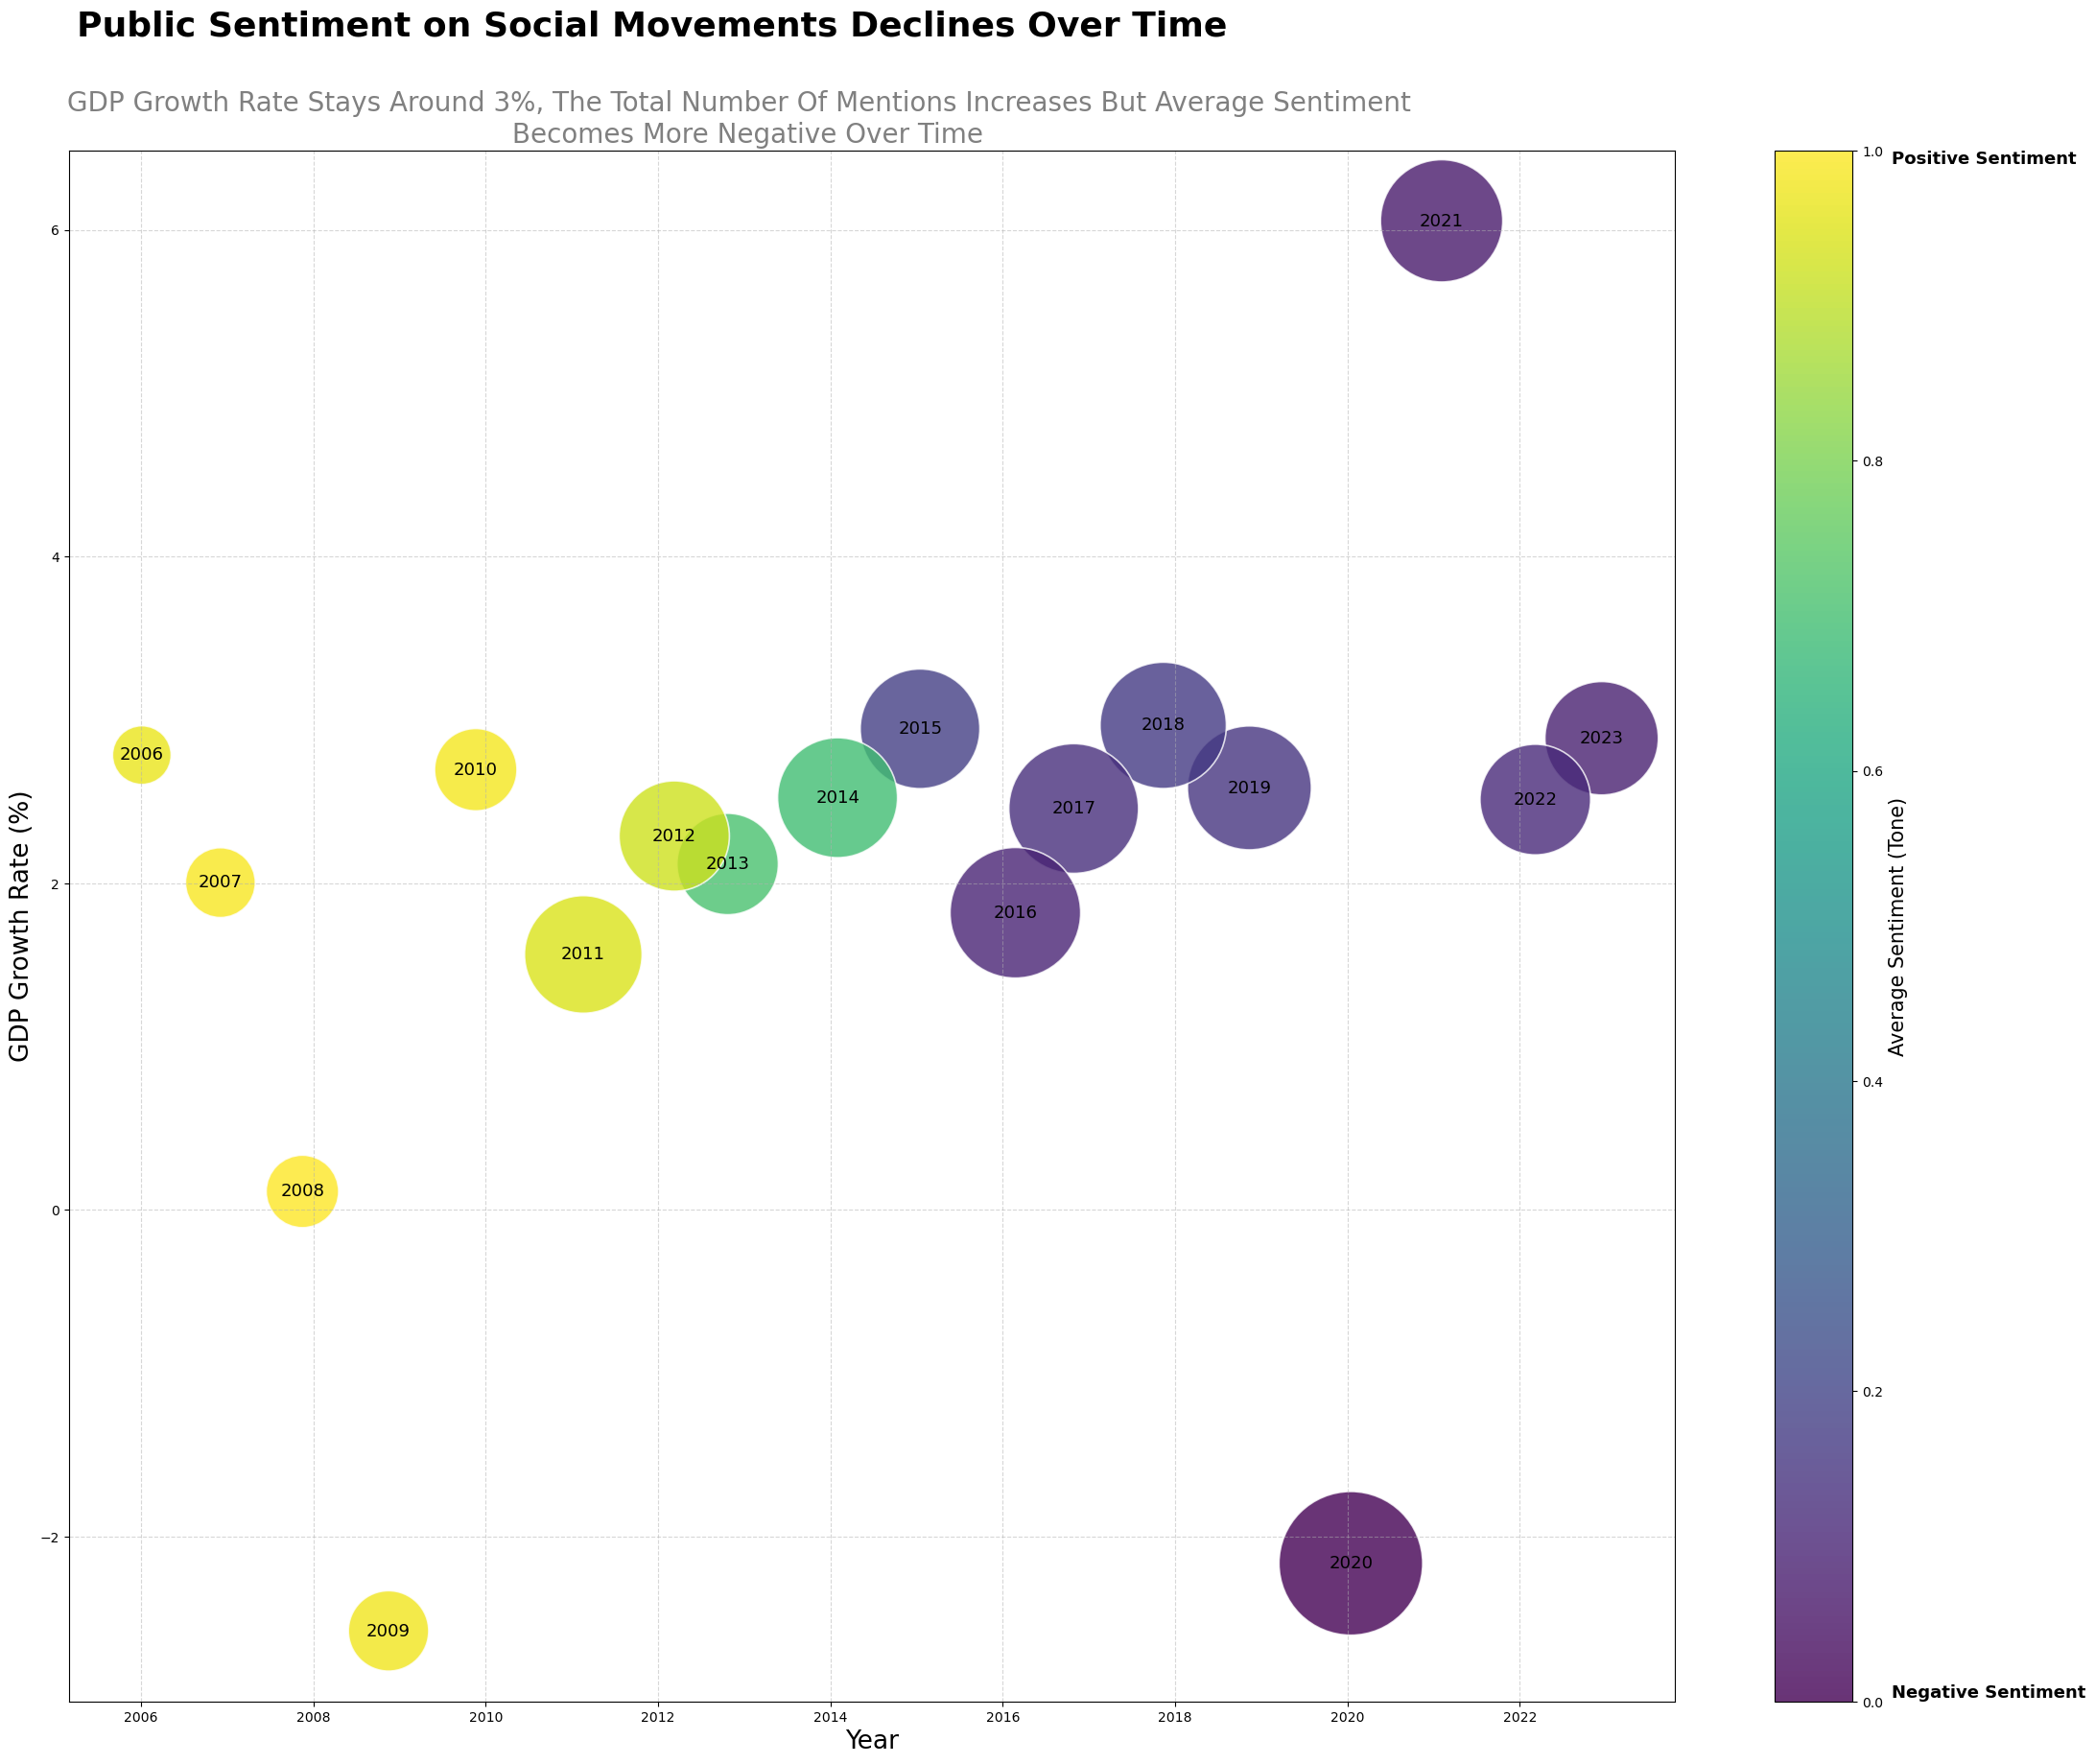

In [76]:
# Connect to SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDP data
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_df = pd.read_sql_query(gdp_query, conn)

# Query Social Movements data
social_query = """
SELECT SUBSTR(Date, 1, 4) AS Year, COUNT(*) AS NumMentions, AVG(AvgTone) AS AvgTone
FROM SocialMovements
GROUP BY Year
ORDER BY Year;
"""
social_df = pd.read_sql_query(social_query, conn)

# Ensure date column is in datetime format
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract Year from GDP data and convert to integer
gdp_df["Year"] = gdp_df["Date"].dt.year.astype(int)

# Convert Year column in social_df to integer
social_df["Year"] = social_df["Year"].astype(int)

# Calculate GDP growth rate
gdp_df = gdp_df.sort_values("Year", ascending=True) # Sort by Year in ascending order to ensure correct GDP growth calculation
gdp_df["GDP_Growth"] = ((gdp_df["GDP_Billions"] - gdp_df["GDP_Billions"].shift(1)) / gdp_df["GDP_Billions"].shift(1)) * 100
gdp_df.dropna(inplace=True)
gdp_df = gdp_df.sort_values("Year", ascending=False)

# Merge GDP and social movements data on Year
merged_df = pd.merge(gdp_df, social_df, on="Year", how="inner")

# Jittering to avoid overlap
np.random.seed(42)  # For consistent results
jitter = np.random.uniform(-0.2, 0.2, size=len(merged_df))

# === Colorblind-Friendly Palette ===
# "viridis" is great for colorblind users (monotonic perceptual scale)
cmap = plt.cm.viridis

# Normalize AvgTone values to match colormap
norm = mcolors.Normalize(vmin=merged_df["AvgTone"].min(), vmax=merged_df["AvgTone"].max())

# Create Bubble Chart with Adjustments
plt.figure(figsize=(27,21))
scatter = plt.scatter(
    merged_df["Year"] + jitter,  # Jitter applied to Year for visibility
    merged_df["GDP_Growth"], 
    s=np.sqrt(merged_df["NumMentions"]) * 100,  # Use sqrt scale for better spread
    c=cmap(norm(merged_df["AvgTone"])),  # Apply color mapping from viridis
    alpha=0.8,  # Higher opacity for better visibility
    edgecolors="white",  # White edges improve contrast
    linewidth=1.2  # Make edges thicker for clarity
)

# Add color bar for sentiment
cbar = plt.colorbar(scatter)
cbar.set_label("Average Sentiment (Tone)", fontsize=15)

# Get color bar axis limits
cbar_min, cbar_max = cbar.ax.get_ylim()

# Add labels at the edges in high-contrast colors
cbar.ax.text(1.5, cbar_min, "Negative Sentiment", va="bottom", ha="left", fontsize=13, color="black", weight="bold")
cbar.ax.text(1.5, cbar_max, "Positive Sentiment", va="top", ha="left", fontsize=13, color="black", weight="bold")

# Add annotations for individual years
for i, row in merged_df.iterrows():
    plt.text(row["Year"] + jitter[i], row["GDP_Growth"], str(row["Year"]), fontsize=13, ha='center', va='center', color='black')

# Adjustable title positions
suptitle_x = 0.35
suptitle_y = 0.95

title_x = 0.42
title_y = 1.0  

# Add Main Title (suptitle) & Subtitle with Position Adjustments
plt.suptitle(
    "Public Sentiment on Social Movements Declines Over Time",
    fontsize=26, weight="bold", x=suptitle_x, y=suptitle_y
)

plt.title(
    "GDP Growth Rate Stays Around 3%, The Total Number Of Mentions Increases But Average Sentiment \n Becomes More Negative Over Time", 
    fontsize=20, color="gray", x=title_x, y=title_y
)


plt.xlabel("Year", fontsize=19)
plt.ylabel("GDP Growth Rate (%)", fontsize=19)
plt.xticks(np.arange(merged_df["Year"].min(), merged_df["Year"].max() + 1, 2))  # Set x-axis intervals to 2 years
plt.grid(True, linestyle="--", alpha=0.5)

# Save figure as SVG (scalable format)
svg_file_path = "../../website/figures/bubble_graph.svg" 
plt.savefig(svg_file_path, format='svg', transparent=True)

plt.show()

conn.close()


## 3. Interactive line graph of GDP and average sentiment

In [11]:
keywords = {
    'Black Lives Matter': ['blm', 'black-lives-matter'],
    'Me Too': ['me-too', 'metoo', 'me-too-movement'],
    'Climate Change': ['climate-change', 'global-warming'],
    'LGBTQ+ Rights': ['lgbtq', 'pride', 'gay-rights'],
    'Gun Control': ['gun-control', 'gun-violence', 'nra'],
    'Immigration': ['immigration', 'border', 'migrant', 'refugee'],
    'Women\'s Rights': ['women-rights', 'gender-equality', 'feminism'],
    'Native American Rights': ['native-american-rights', 'indigenous-rights', 'tribal-sovereignty'],
    'Healthcare Reform': ['healthcare-reform', 'obamacare', 'medicare-for-all'],
    'Workers\' Rights': ['labor-rights', 'union', 'workers-strike', 'minimum-wage'],
    'Education Reform': ['education-reform', 'student-loans', 'teacher-strike'],
    'Voting Rights': ['voting-rights', 'voter-suppression', 'election-reform'],
}


In [38]:
# Open database connection
database_path = "../../data/processed/social_movements.db"
db_connection = sqlite3.connect(database_path)

# Initialize dictionary to store sentiment data for social movements
social_movement_sentiments = {}

# Query sentiment data for each movement
for movement_name, keyword_list in keywords.items():
    search_conditions = " OR ".join([f"SOURCEURL LIKE '%{keyword}%'" for keyword in keyword_list])
    
    sentiment_query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        AVG(AvgTone) AS AverageSentiment
    FROM SocialMovements
    WHERE {search_conditions}
    GROUP BY Year
    ORDER BY Year;
    """

    # Execute query and store results in dictionary
    sentiment_dataframe = pd.read_sql_query(sentiment_query, db_connection)
    
    # Store only non-empty datasets
    if not sentiment_dataframe.empty:
        social_movement_sentiments[movement_name] = sentiment_dataframe

# Query GDP data
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_dataframe = pd.read_sql_query(gdp_query, db_connection)

# Extract Year from the 'Date' column and convert to integer
gdp_dataframe["Year"] = pd.to_datetime(gdp_dataframe["Date"]).dt.year.astype(int)

# Ensure "Year" column in all sentiment data is integer type
for movement in social_movement_sentiments:
    social_movement_sentiments[movement]["Year"] = social_movement_sentiments[movement]["Year"].astype(int)

# Merge GDP data with sentiment data for each movement
merged_sentiment_gdp_data = {}
for movement, sentiment_data in social_movement_sentiments.items():
    merged_dataframe = pd.merge(sentiment_data, gdp_dataframe[['Year', 'GDP_Billions']], on="Year", how="inner")
    merged_sentiment_gdp_data[movement] = merged_dataframe

# Compute "Average Sentiment Effect" across all movements
concatenated_sentiments = pd.concat([df[['Year', 'AverageSentiment']] for df in merged_sentiment_gdp_data.values()])
yearly_average_sentiment = concatenated_sentiments.groupby('Year').mean().reset_index()

# Merge with GDP data and ensure proper sorting
average_sentiment_with_gdp = pd.merge(yearly_average_sentiment, gdp_dataframe[['Year', 'GDP_Billions']], on='Year', how='left')
sorted_average_sentiment = average_sentiment_with_gdp.sort_values('GDP_Billions')

# Create interactive plot using Plotly
fig = go.Figure()

# Add a line for "Average Sentiment Effect"
fig.add_trace(go.Scatter(
    x=sorted_average_sentiment['GDP_Billions'],  # Use the correct variable name
    y=sorted_average_sentiment['AverageSentiment'],
    mode='lines+markers',
    name='Average Sentiment Effect',
    line=dict(color='black', width=3, dash="dashdot"),
    opacity=0.8
))

# Configure layout
fig.update_layout(
    title="As GDP Increases, The Average Sentiment Towards Social Movements Becomes Negative",
    xaxis_title="GDP (Billions of US$)",
    yaxis_title="Average Sentiment Score",
    template="plotly_white",
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        zeroline=True,
        zerolinecolor='black',  # Highlight Y=0 line
        gridcolor='gray',  # Subtle grid lines
        range=[-5, 5]  # Ensuring a balanced sentiment scale
    )
)

# Display the figure
fig.show()


# Close the database connection
db_connection.close()


I made the graph below have a title and subtitle.

In [27]:
# Open database connection
database_path = "../../data/processed/social_movements.db"
db_connection = sqlite3.connect(database_path)

# Initialize dictionary to store sentiment data for social movements
social_movement_sentiments = {}

# Query sentiment data for each movement
for movement_name, keyword_list in keywords.items():
    search_conditions = " OR ".join([f"SOURCEURL LIKE '%{keyword}%'" for keyword in keyword_list])
    
    sentiment_query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        AVG(AvgTone) AS AverageSentiment
    FROM SocialMovements
    WHERE {search_conditions}
    GROUP BY Year
    ORDER BY Year;
    """

    # Execute query and store results in dictionary
    sentiment_dataframe = pd.read_sql_query(sentiment_query, db_connection)
    
    # Store only non-empty datasets
    if not sentiment_dataframe.empty:
        social_movement_sentiments[movement_name] = sentiment_dataframe

# Query GDP data
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_dataframe = pd.read_sql_query(gdp_query, db_connection)

# Extract Year from the 'Date' column and convert to integer
gdp_dataframe["Year"] = pd.to_datetime(gdp_dataframe["Date"]).dt.year.astype(int)

# Ensure "Year" column in all sentiment data is integer type
for movement in social_movement_sentiments:
    social_movement_sentiments[movement]["Year"] = social_movement_sentiments[movement]["Year"].astype(int)

# Merge GDP data with sentiment data for each movement
merged_sentiment_gdp_data = {}
for movement, sentiment_data in social_movement_sentiments.items():
    merged_dataframe = pd.merge(sentiment_data, gdp_dataframe[['Year', 'GDP_Billions']], on="Year", how="inner")
    merged_sentiment_gdp_data[movement] = merged_dataframe


# Compute "Average Sentiment Effect" across all movements
concatenated_sentiments = pd.concat([df[['Year', 'AverageSentiment']] for df in merged_sentiment_gdp_data.values()])
yearly_average_sentiment = concatenated_sentiments.groupby('Year').mean().reset_index()

# Merge with GDP data and ensure proper sorting
average_sentiment_with_gdp = pd.merge(yearly_average_sentiment, gdp_dataframe[['Year', 'GDP_Billions']], on='Year', how='left')
sorted_average_sentiment = average_sentiment_with_gdp.sort_values('GDP_Billions')

# Create interactive plot using Plotly
fig = go.Figure()

# Add a line for "Average Sentiment Effect"
fig.add_trace(go.Scatter(
    x=sorted_average_sentiment['GDP_Billions'],  
    y=sorted_average_sentiment['AverageSentiment'],
    mode='lines+markers',
    name='Average Sentiment Effect',
    line=dict(color='black', width=3, dash="dashdot"),
    opacity=0.8
))

# Configure layout
fig.update_layout(
    title="Average Sentiment Towards Social Movements vs GDP",
    title_font=dict(size=24, family="Arial, sans-serif", color="black"),
    
    annotations=[
        dict(
            x=-0.03,
            y=1.18,
            xref="paper",
            yref="paper",
            text="As GDP Increases, The Average Sentiment Towards Social Movements Becomes Negative",
            showarrow=False,
            font=dict(size=16, color="gray"),  # Subtitle text style
            align="center"
        )
    ],

        yaxis=dict(
        zeroline=True, 
        zerolinecolor='black',  # Darker color for the y=0 line
        gridcolor='gray',  # Grid lines color
        showgrid=True
    ),
    
    xaxis_title="GDP (Billions of US$)",
    yaxis_title="Average Sentiment (AvgTone)",
    template="plotly_white",  # Clean theme
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper/figure to transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent
)

# Display the figure
fig.show()

# Close the database connection
db_connection.close()


In [41]:
# Open database connection
database_path = "../../data/processed/social_movements.db"
db_connection = sqlite3.connect(database_path)

# Initialize dictionary to store sentiment data for social movements
social_movement_sentiments = {}

# Query sentiment data for each movement
for movement_name, keyword_list in keywords.items():
    search_conditions = " OR ".join([f"SOURCEURL LIKE '%{keyword}%'" for keyword in keyword_list])
    
    sentiment_query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        AVG(AvgTone) AS AverageSentiment
    FROM SocialMovements
    WHERE {search_conditions}
    GROUP BY Year
    ORDER BY Year;
    """

    # Execute query and store results in dictionary
    sentiment_dataframe = pd.read_sql_query(sentiment_query, db_connection)
    
    # Store only non-empty datasets
    if not sentiment_dataframe.empty:
        social_movement_sentiments[movement_name] = sentiment_dataframe

# Query GDP data
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_dataframe = pd.read_sql_query(gdp_query, db_connection)

# Extract Year from the 'Date' column and convert to integer
gdp_dataframe["Year"] = pd.to_datetime(gdp_dataframe["Date"]).dt.year.astype(int)

# Ensure "Year" column in all sentiment data is integer type
for movement in social_movement_sentiments:
    social_movement_sentiments[movement]["Year"] = social_movement_sentiments[movement]["Year"].astype(int)

# Merge GDP data with sentiment data for each movement
merged_sentiment_gdp_data = {}
for movement, sentiment_data in social_movement_sentiments.items():
    merged_dataframe = pd.merge(sentiment_data, gdp_dataframe[['Year', 'GDP_Billions']], on="Year", how="inner")
    merged_sentiment_gdp_data[movement] = merged_dataframe


# Compute "Average Sentiment Effect" across all movements
concatenated_sentiments = pd.concat([df[['Year', 'AverageSentiment']] for df in merged_sentiment_gdp_data.values()])
yearly_average_sentiment = concatenated_sentiments.groupby('Year').mean().reset_index()

# Merge with GDP data and ensure proper sorting
average_sentiment_with_gdp = pd.merge(yearly_average_sentiment, gdp_dataframe[['Year', 'GDP_Billions']], on='Year', how='left')
sorted_average_sentiment = average_sentiment_with_gdp.sort_values('GDP_Billions')

# Create interactive plot using Plotly
fig = go.Figure()

# Add a line for "Average Sentiment Effect"
fig.add_trace(go.Scatter(
    x=sorted_average_sentiment['GDP_Billions'],  
    y=sorted_average_sentiment['AverageSentiment'],
    mode='lines+markers',
    name='Average Sentiment Effect',
    line=dict(color='black', width=3, dash="dashdot"),
    opacity=0.8
))

import numpy as np

# Identify zero crossings
x_vals = sorted_average_sentiment['GDP_Billions'].values
y_vals = sorted_average_sentiment['AverageSentiment'].values

pos_x, pos_y = [], []
neg_x, neg_y = [], []

for i in range(len(y_vals) - 1):
    x1, y1 = x_vals[i], y_vals[i]
    x2, y2 = x_vals[i + 1], y_vals[i + 1]

    # If both points are above zero, add to positive list
    if y1 > 0 and y2 > 0:
        pos_x.append(x1)
        pos_y.append(y1)

    # If both points are below zero, add to negative list
    elif y1 < 0 and y2 < 0:
        neg_x.append(x1)
        neg_y.append(y1)

    # If a zero crossing occurs, interpolate the exact crossing point
    elif y1 * y2 < 0:
        x_cross = x1 - y1 * (x2 - x1) / (y2 - y1)  # Linear interpolation
        y_cross = 0  # Always at y=0

        pos_x.append(x1) if y1 > 0 else neg_x.append(x1)
        pos_y.append(y1) if y1 > 0 else neg_y.append(y1)

        pos_x.append(x_cross)
        pos_y.append(y_cross)
        neg_x.append(x_cross)
        neg_y.append(y_cross)

# Ensure last point is included
if y_vals[-1] > 0:
    pos_x.append(x_vals[-1])
    pos_y.append(y_vals[-1])
else:
    neg_x.append(x_vals[-1])
    neg_y.append(y_vals[-1])

# Create interactive plot using Plotly
fig = go.Figure()

# Add a line for "Average Sentiment Effect"
fig.add_trace(go.Scatter(
    x=x_vals,  
    y=y_vals,
    mode='lines+markers',
    name='Average Sentiment Effect',
    line=dict(color='black', width=3, dash="dashdot"),
    opacity=0.8
))

# Add green fill for positive sentiment (above y=0)
fig.add_trace(go.Scatter(
    x=pos_x,
    y=pos_y,
    fill='tozeroy',
    mode='none',  # Hide line markers
    fillcolor='rgba(0, 200, 0, 0.3)',  # Semi-transparent green
    name="Positive Sentiment Region"
))

# Add red fill for negative sentiment (below y=0)
fig.add_trace(go.Scatter(
    x=neg_x,
    y=neg_y,
    fill='tozeroy',
    mode='none',
    fillcolor='rgba(200, 0, 0, 0.3)',  # Semi-transparent red
    name="Negative Sentiment Region"
))

# Configure layout
fig.update_layout(
    title="Average Sentiment Towards Social Movements vs GDP",
    title_font=dict(size=24, family="Arial, sans-serif", color="black"),
    
    annotations=[
        dict(
            x=-0.03,
            y=1.18,
            xref="paper",
            yref="paper",
            text="As GDP Increases, The Average Sentiment Towards Social Movements Becomes Negative",
            showarrow=False,
            font=dict(size=16, color="gray"),  # Subtitle text style
            align="center"
        )
    ],

    yaxis=dict(
        zeroline=True, 
        zerolinecolor='black',  # Darker y=0 line
        zerolinewidth=2,  # Make y=0 line thicker
        gridcolor='gray',  # Grid lines color
        showgrid=True
    ),
    
    xaxis_title="GDP (Billions of US$)",
    yaxis_title="Average Sentiment (AvgTone)",
    template="plotly_white",  # Clean theme
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper/figure to transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent
)

# Display the figure
fig.show()

# Save as an interactive HTML file
output_path = "../../website/figures/average_social_movements_interactive_plot.html"
pio.write_html(fig, output_path)

# Close the database connection
db_connection.close()


In [44]:
# Open database connection
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Initialize a dictionary to store movement data
movement_data = {}

# Generate dynamic queries for each movement
for movement, terms in keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        AVG(AvgTone) AS AvgTone
    FROM SocialMovements
    WHERE {term_conditions}
    GROUP BY Year
    ORDER BY Year;
    """
    
    # Execute query and store results in movement_data dictionary
    movement_data[movement] = pd.read_sql_query(query, conn)

# Clean up movement_data to remove empty datasets
movement_data = {movement: data for movement, data in movement_data.items() if not data.empty}

# Load GDP data (adjusted to use 'Date' and extract year)
gdp_query = "SELECT Date, GDP_Billions FROM FRED"
gdp_df = pd.read_sql_query(gdp_query, conn)

# Extract Year from the 'Date' column
gdp_df["Year"] = pd.to_datetime(gdp_df["Date"]).dt.year

# Ensure Year columns are of the same type
gdp_df["Year"] = gdp_df["Year"].astype(int)
for movement, data in movement_data.items():
    data["Year"] = data["Year"].astype(int)  # Ensure Year is of type int in each movement

# Merge with GDP data and add "Average Effect" by calculating the overall average sentiment
merged_data = {}
for movement, data in movement_data.items():
    merged_df = pd.merge(data, gdp_df[['Year', 'GDP_Billions']], on="Year", how="inner")
    merged_data[movement] = merged_df

# Add the "Average Effect" data
average_effect_data = pd.concat([df[['Year', 'AvgTone']] for df in merged_data.values()])
average_effect_data = average_effect_data.groupby('Year').mean().reset_index()
average_effect_data['GDP_Billions'] = pd.merge(average_effect_data, gdp_df[['Year', 'GDP_Billions']], on='Year', how='left')['GDP_Billions']

# Sort each movement's data by GDP_Billions to ensure points are connected to the nearest right point
for movement in merged_data:
    merged_data[movement] = merged_data[movement].sort_values('GDP_Billions')

# Sort Average Effect data by GDP_Billions to ensure it's ordered properly
average_effect_data = average_effect_data.sort_values('GDP_Billions')

# Plot the data using Plotly for an interactive line graph
fig = go.Figure()

# Define medium/dark colors for each movement (use colors from Plotly's color scale)
colors = px.colors.qualitative.Dark24

# Add lines for each movement
for idx, (movement, data) in enumerate(merged_data.items()):
    fig.add_trace(go.Scatter(
        x=data['GDP_Billions'],
        y=data['AvgTone'],
        mode='lines+markers',  # Use lines and markers
        name=movement,
        line=dict(color=colors[idx % len(colors)]),  # Use different color for each movement
        opacity=0.7
    ))

# Add the "Average Effect" line
fig.add_trace(go.Scatter(
    x=average_effect_data['GDP_Billions'],
    y=average_effect_data['AvgTone'],
    mode='lines+markers',
    name='Average Effect',
    line=dict(color='black'),
    opacity=0.7
))

# Create visibility list and buttons dynamically based on the available movements
visibility = [True] * len(merged_data) + [True]  # Initially show all movements and average effect

# Create buttons dynamically for each movement
buttons = [
    {
        'label': 'Show All Movements',
        'method': 'update',
        'args': [{'visible': visibility}, {'title': 'Sentiment for All Movements'}]
    },
    {
        'label': 'Average Effect',
        'method': 'update',
        'args': [{'visible': [False] * len(merged_data) + [True]}, {'title': 'Average Effect'}]
    }
]

# Add a button for each movement
for idx, movement in enumerate(merged_data.keys()):
    visibility_list = [False] * len(merged_data)
    visibility_list[idx] = True  # Only show the selected movement
    buttons.append({
        'label': movement,
        'method': 'update',
        'args': [{'visible': visibility_list + [False]}, {'title': f"Sentiment for {movement}"}]
    })

# Update layout with dynamic buttons
fig.update_layout(
    title="Sentiment Towards Social Movements vs GDP",
    xaxis_title="GDP (Billions of US$)",
    yaxis_title="Average Sentiment (AvgTone)",
    template="plotly_white",  # Clean theme
    paper_bgcolor='rgba(0,0,0,0)', # Set paper/figure to transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent
    yaxis=dict(
        zeroline=True,
        zerolinecolor='black',  # Make the Y=0 line dark black
        gridcolor='gray'  # Set grid lines to gray
    ),
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.2,
        'y': 1.10,
        'yanchor': 'top'
    }]
)

fig.show()

pio.write_html(fig, "../../website/figures/social_movements_interactive_plot.html")

# Close the connection after all operations are done
conn.close()
